<h1 style="color: #3287a8; text-align: center; font-size: 42px">Scientific Computing with Python Final Project</h1>


## Assaf Gutman 300174455 
## Eytan Ohana 803422

<hr style="border: 10px dotted #a6a6a6;
           border-style: none none dotted; 
           color: #fff; 
           background-color: #fff;
           margin: 20px 45%;">
           
           
Our data comes from an online casino with players all around the world. Our aim is to estimate the distributions of **time till conversion** and **RTP** for the players. 

**Time till conversion** is defined as the number of days a player takes from initially signing up for the service till they make their first deposit. We expect that the time till conversion follows a poisson distribution with parameter $\lambda = 1.$ 

**RTP** is defined as the Return to Player meaning the percentage of money a player wins back from his or her bet. We expect that the RTP follows a normal distribution with mean $\mu = 93$ and standard deviation $\sigma = 20$.


# Calculating the Distribution of time till Conversion

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import emcee
from mpl_toolkits.mplot3d import axes3d
from warnings import filterwarnings
import datetime

red, blue, green = sns.color_palette('Set1', 3)
sns.set()
filterwarnings('ignore')

In [27]:
df = pd.read_csv('days from signup to deposit.csv')
df.head()

,SignupDate,CountryName,CustomerID,Bonuses,DepositDate,DateDiff
0,2020-08-30,Sweden,880393,0.0000,2020-08-30,0
1,2020-08-30,Germany,880415,28.5000,2020-08-30,0
2,2020-08-30,Canada,880467,13.3586,2020-08-30,0
3,2020-08-30,Sweden,880477,3.4136,2020-08-30,0
4,2020-08-30,Sweden,880499,0.0000,2020-08-30,0


In [28]:
df['DepositDate'] = pd.to_datetime(df.DepositDate)
df['SignupDate'] = pd.to_datetime(df.SignupDate)
df['CustomerID'] = pd.to_numeric(df.CustomerID)
df.dtypes

SignupDate     datetime64[ns]
CountryName            object
CustomerID              int64
Bonuses               float64
DepositDate    datetime64[ns]
DateDiff                int64
dtype: object

In [29]:
# We only care to analyze data from the passed 
# two years meaning 2019 and onwards.# 
year_2019 = datetime.datetime(2019, 1, 1)

df = df[(df.SignupDate >= year_2019) ]

In [30]:
print(f'There are {df.CustomerID.nunique():,} customers from', 
      df.CountryName.nunique(), 'countries.')

There are 643,482 customers from 144 countries.


In [31]:
df.describe()

,CustomerID,Bonuses,DateDiff
count,6.439600e+05,643960.000000,643960.000000
mean,3.316277e+11,8.293237,0.839169
std,4.585296e+11,85.969937,19.955567
min,4.599560e+05,-24319.780900,-1.000000
25%,6.358978e+05,0.000000,-1.000000
50%,8.061545e+05,0.000000,-1.000000
75%,1.000000e+12,1.400000,-1.000000
max,1.000001e+12,31944.000000,597.000000


<hr style="border: 10px dotted #a6a6a6;
           border-style: none none dotted; 
           color: #fff; 
           background-color: #fff;
           margin: 5px 45%;">

We only care about countries with more than 10,000 players so we add the column `CountryID` which is an exact copy of `CountryName` except we replace countries with less than 10,000 players with the value **ROW** meaning Rest of World.

In [32]:
countries_lt_10000 = (df.CountryName.value_counts() < 10_000).index[
                        df.CountryName.value_counts() < 10_000]

countries_lt_10000

Index(['India', 'Austria', 'Switzerland', 'Poland', 'Malta',
       'Russian Federation', 'Egypt', 'Ukraine', 'Thailand', 'Japan',
       ...
       'Saint Kitts And Nevis', 'Guyana', 'Sint Maarten', 'Equatorial Guinea',
       'Central African Republic', 'Sierra Leone', 'Timor-Leste', 'Tuvalu',
       'Czech Republic', 'Samoa'],
      dtype='object', length=136)

In [33]:
df['CountryID'] = df.CountryName.copy()

# ROW = Rest Of World
df.loc[df.CountryName.isin(countries_lt_10000), 'CountryID'] = 'ROW'

df.CountryID.value_counts()

Netherlands       127828
Germany           126033
New Zealand       120489
Sweden             64150
Finland            58511
Norway             43345
Canada             40441
ROW                32078
United Kingdom     31085
Name: CountryID, dtype: int64

# Shift DateDiff column up 1 unit

We add 1 to the `DateDiff` column to shift the range from -1 -> ~1200 to 0 -> ~1201.

-1 was originally the value signifying a null value meaning there is no `DepositDate` value for the given customer and 0 is now the null value.

This helps in estimating the parameter $\lambda$ of the poisson distribution which doesn't accept negative values.

In [34]:
df['DateDiff'] += 1
df

,SignupDate,CountryName,CustomerID,Bonuses,DepositDate,DateDiff,CountryID
0,2020-08-30,Sweden,880393,0.0000,2020-08-30,1,Sweden
1,2020-08-30,Germany,880415,28.5000,2020-08-30,1,Germany
2,2020-08-30,Canada,880467,13.3586,2020-08-30,1,Canada
3,2020-08-30,Sweden,880477,3.4136,2020-08-30,1,Sweden
4,2020-08-30,Sweden,880499,0.0000,2020-08-30,1,Sweden
...,...,...,...,...,...,...,...
1405562,2019-02-02,Netherlands,486032,0.4500,NaT,0,Netherlands
1405563,2019-04-29,Netherlands,542013,1.0000,NaT,0,Netherlands
1405565,2019-06-27,Netherlands,586644,0.5000,NaT,0,Netherlands
1405568,2019-05-11,Netherlands,550826,1.8000,NaT,0,Netherlands


# Distribution of Time till Conversion of Every Country

Time till Conversion is defined as the time it takes from signing up for the service till when the player puts down a first time deposit.

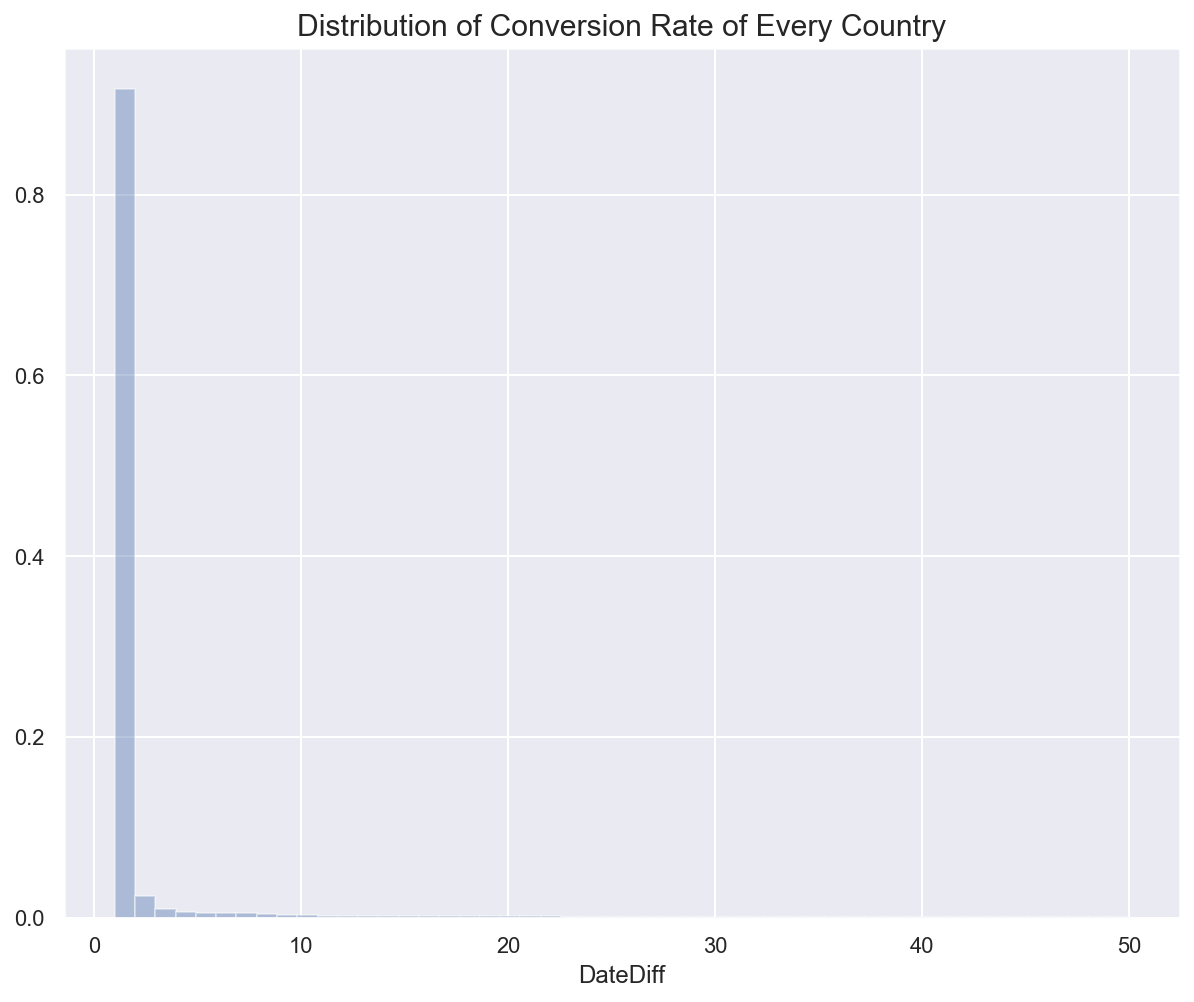

In [35]:
valid_date_diffs = df[(df.DateDiff > 0) & (df.DateDiff < 51)]


plt.figure(figsize=(10,8))
sns.distplot(valid_date_diffs.DateDiff, kde=False, norm_hist=True)
plt.title('Distribution of Conversion Rate of Every Country', fontsize=15);

# Distribution of Time till Conversion by Country

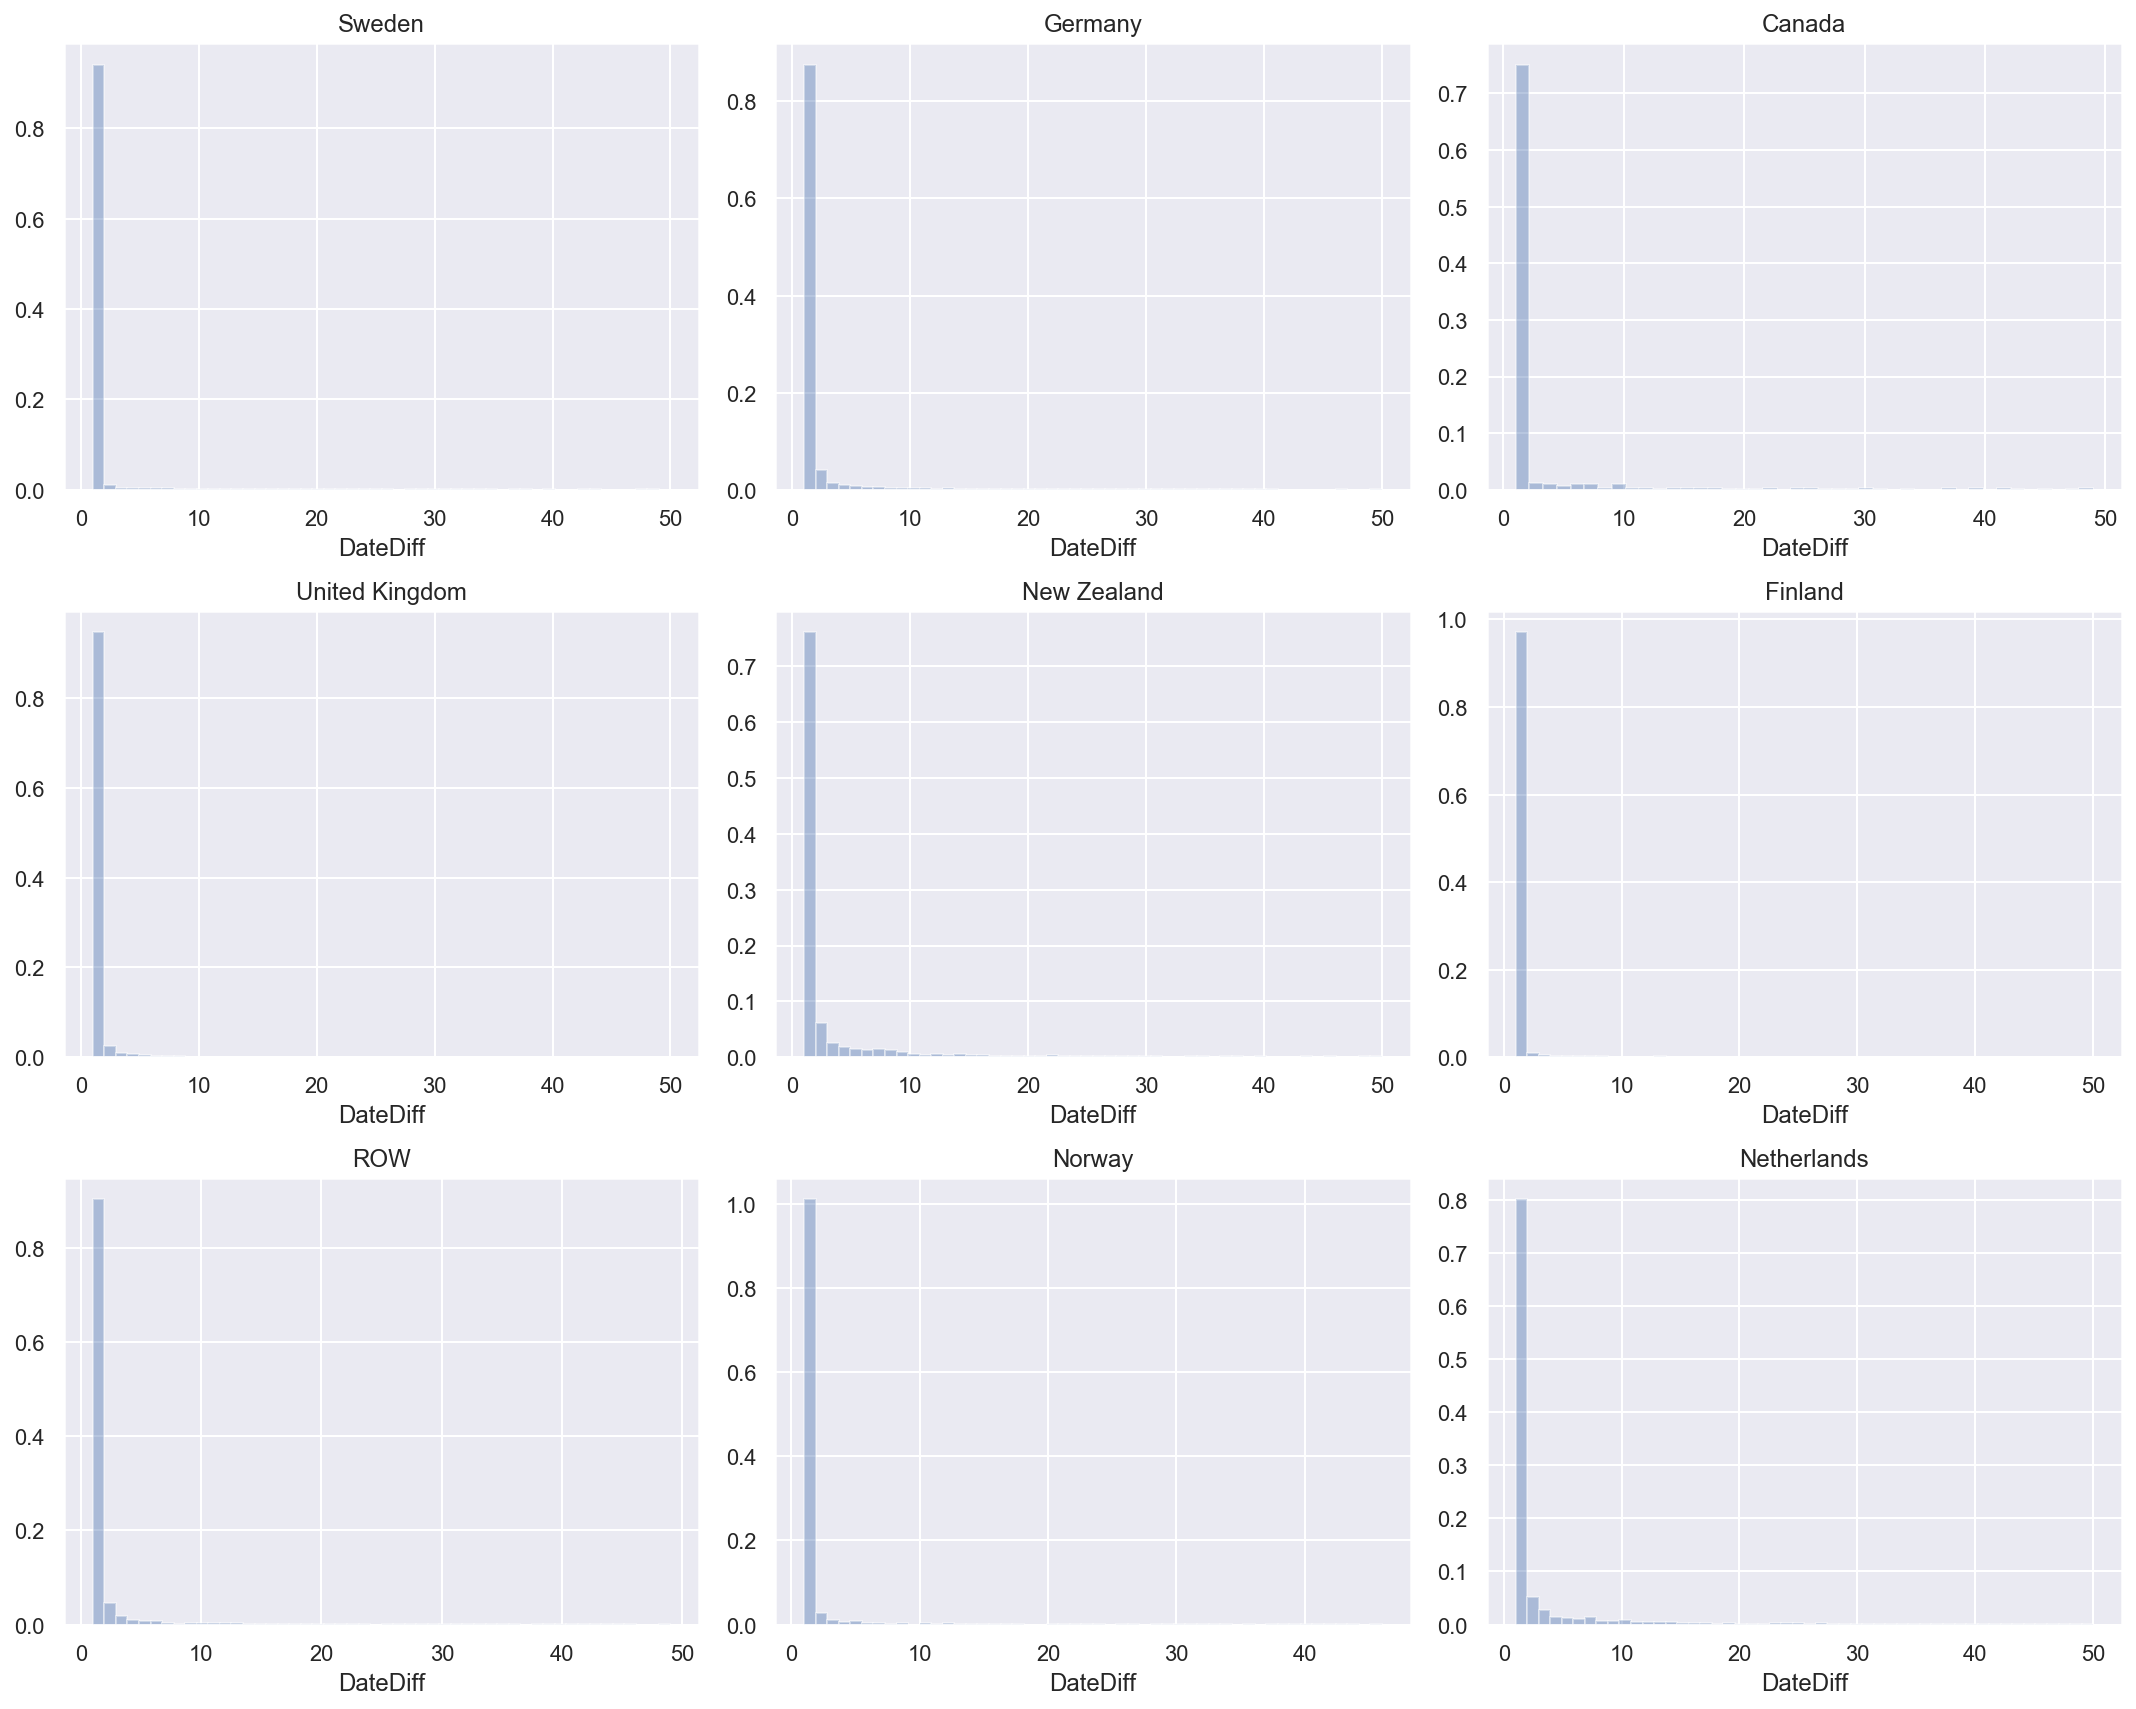

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))

for ax, country in zip(axes.flat, df.CountryID.unique()):
    df_country = df[(df.DateDiff > 0) & (df.DateDiff <= 50)]
    df_country = df_country[df_country.CountryID == country]
    sns.distplot(df_country.DateDiff, kde=False, norm_hist=True, ax=ax)
    ax.set_title(country)
    
plt.tight_layout()

<hr style="border: 10px dotted #a6a6a6;
           border-style: none none dotted; 
           color: #fff; 
           background-color: #fff;
           margin: 20px 45%;">
           
The plots above look very much like poisson distribution with a very high value around 1 this leads us to believe the data is poisson distributed with $\lambda = 1$.

We confirm our suspicions by comparing it with the probability mass function for a poisson distribution with $\lambda = 1$.

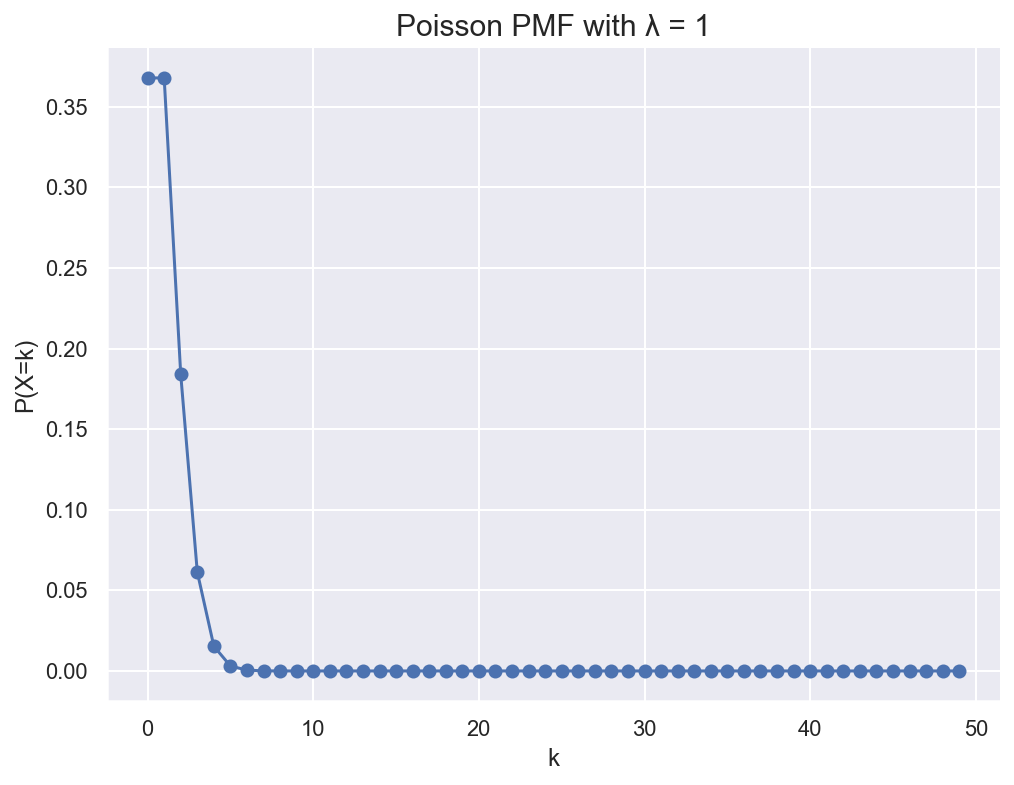

In [37]:
λ = 1
λ_range = np.arange(0, 50)

pmf = stats.poisson.pmf(λ_range, λ)

plt.figure(figsize=(8,6))
plt.plot(λ_range, pmf, '-o')
plt.title('Poisson PMF with λ = 1', fontsize=15)
plt.ylabel('P(X=k)', fontsize=12)
plt.xlabel('k', fontsize=12)
sns.despine()

# MLE for the time till conversion of every country

In [38]:
def log_likelihood(λ, X):
    return stats.poisson(λ).logpmf(X).sum()

λ = 1
λ_hat = 2.15


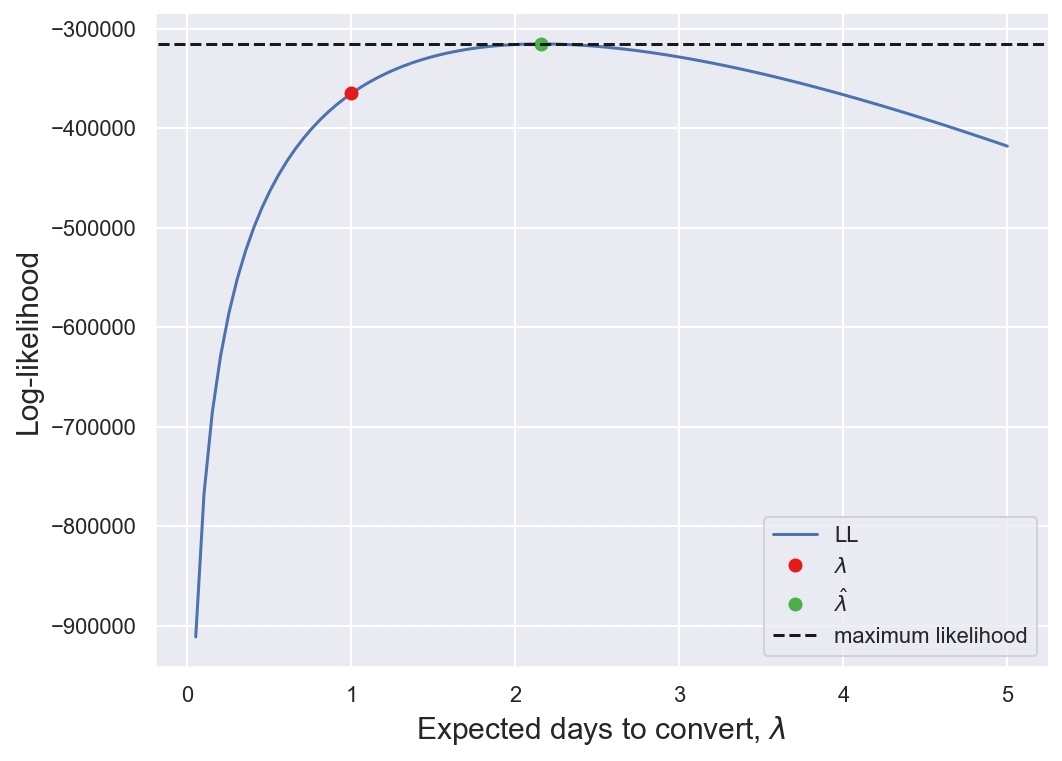

In [39]:
X = valid_date_diffs.DateDiff
λ_hat = X.mean()

print(f'λ = {λ}')
print(f'λ_hat = {λ_hat:.2f}')

λ_range = np.linspace(0, 5, 100)

plt.figure(figsize=(8,6))
plt.plot(λ_range, [log_likelihood(λ_, X) for λ_ in λ_range], label='LL')
plt.plot(λ, log_likelihood(λ, X), 'o', color=red, label='$λ$')
plt.plot(λ_hat, log_likelihood(λ_hat, X), 'o', color=green, label='$\hat{λ}$')

plt.axhline(y=log_likelihood(λ_hat, X), xmin=-1, xmax=λ_hat, ls='--', c='k', label='maximum likelihood')

plt.xlabel("Expected days to convert, $\lambda$", fontsize=15)
plt.ylabel("Log-likelihood", fontsize=15)
plt.legend()
sns.despine()

# The model vs The actual distribution of the data

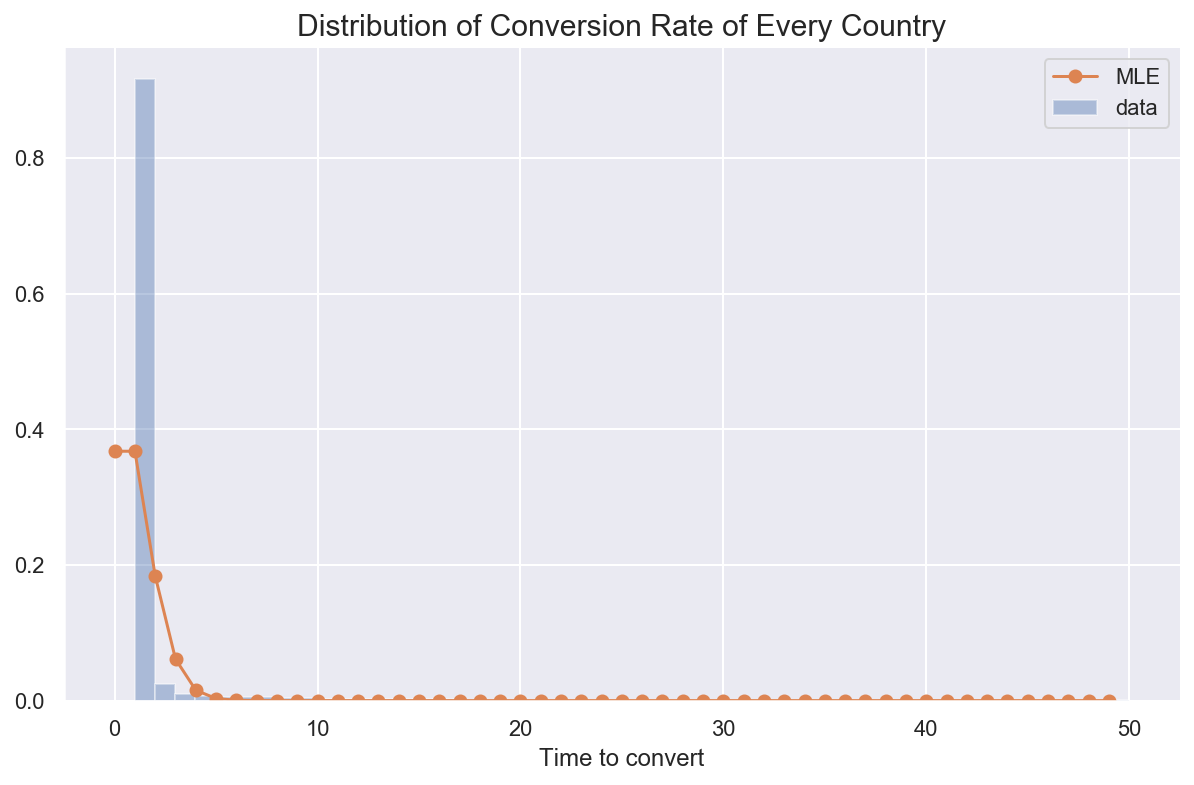

In [40]:
plt.figure(figsize=(10,6))

λ_range = np.arange(0, 50)

plt.title('Distribution of Conversion Rate of Every Country', fontsize=15)
sns.distplot(valid_date_diffs.DateDiff, kde=False, norm_hist=True, label='data')
plt.plot(λ_range, pmf, '-o', label='MLE')
plt.xlabel('Time to convert', fontsize=12)
plt.legend()
sns.despine()

# MLE for the time till conversion of each country

Again by the plots below we still think the data for each country is poisson distributed with parameter $\lambda = 1$. 

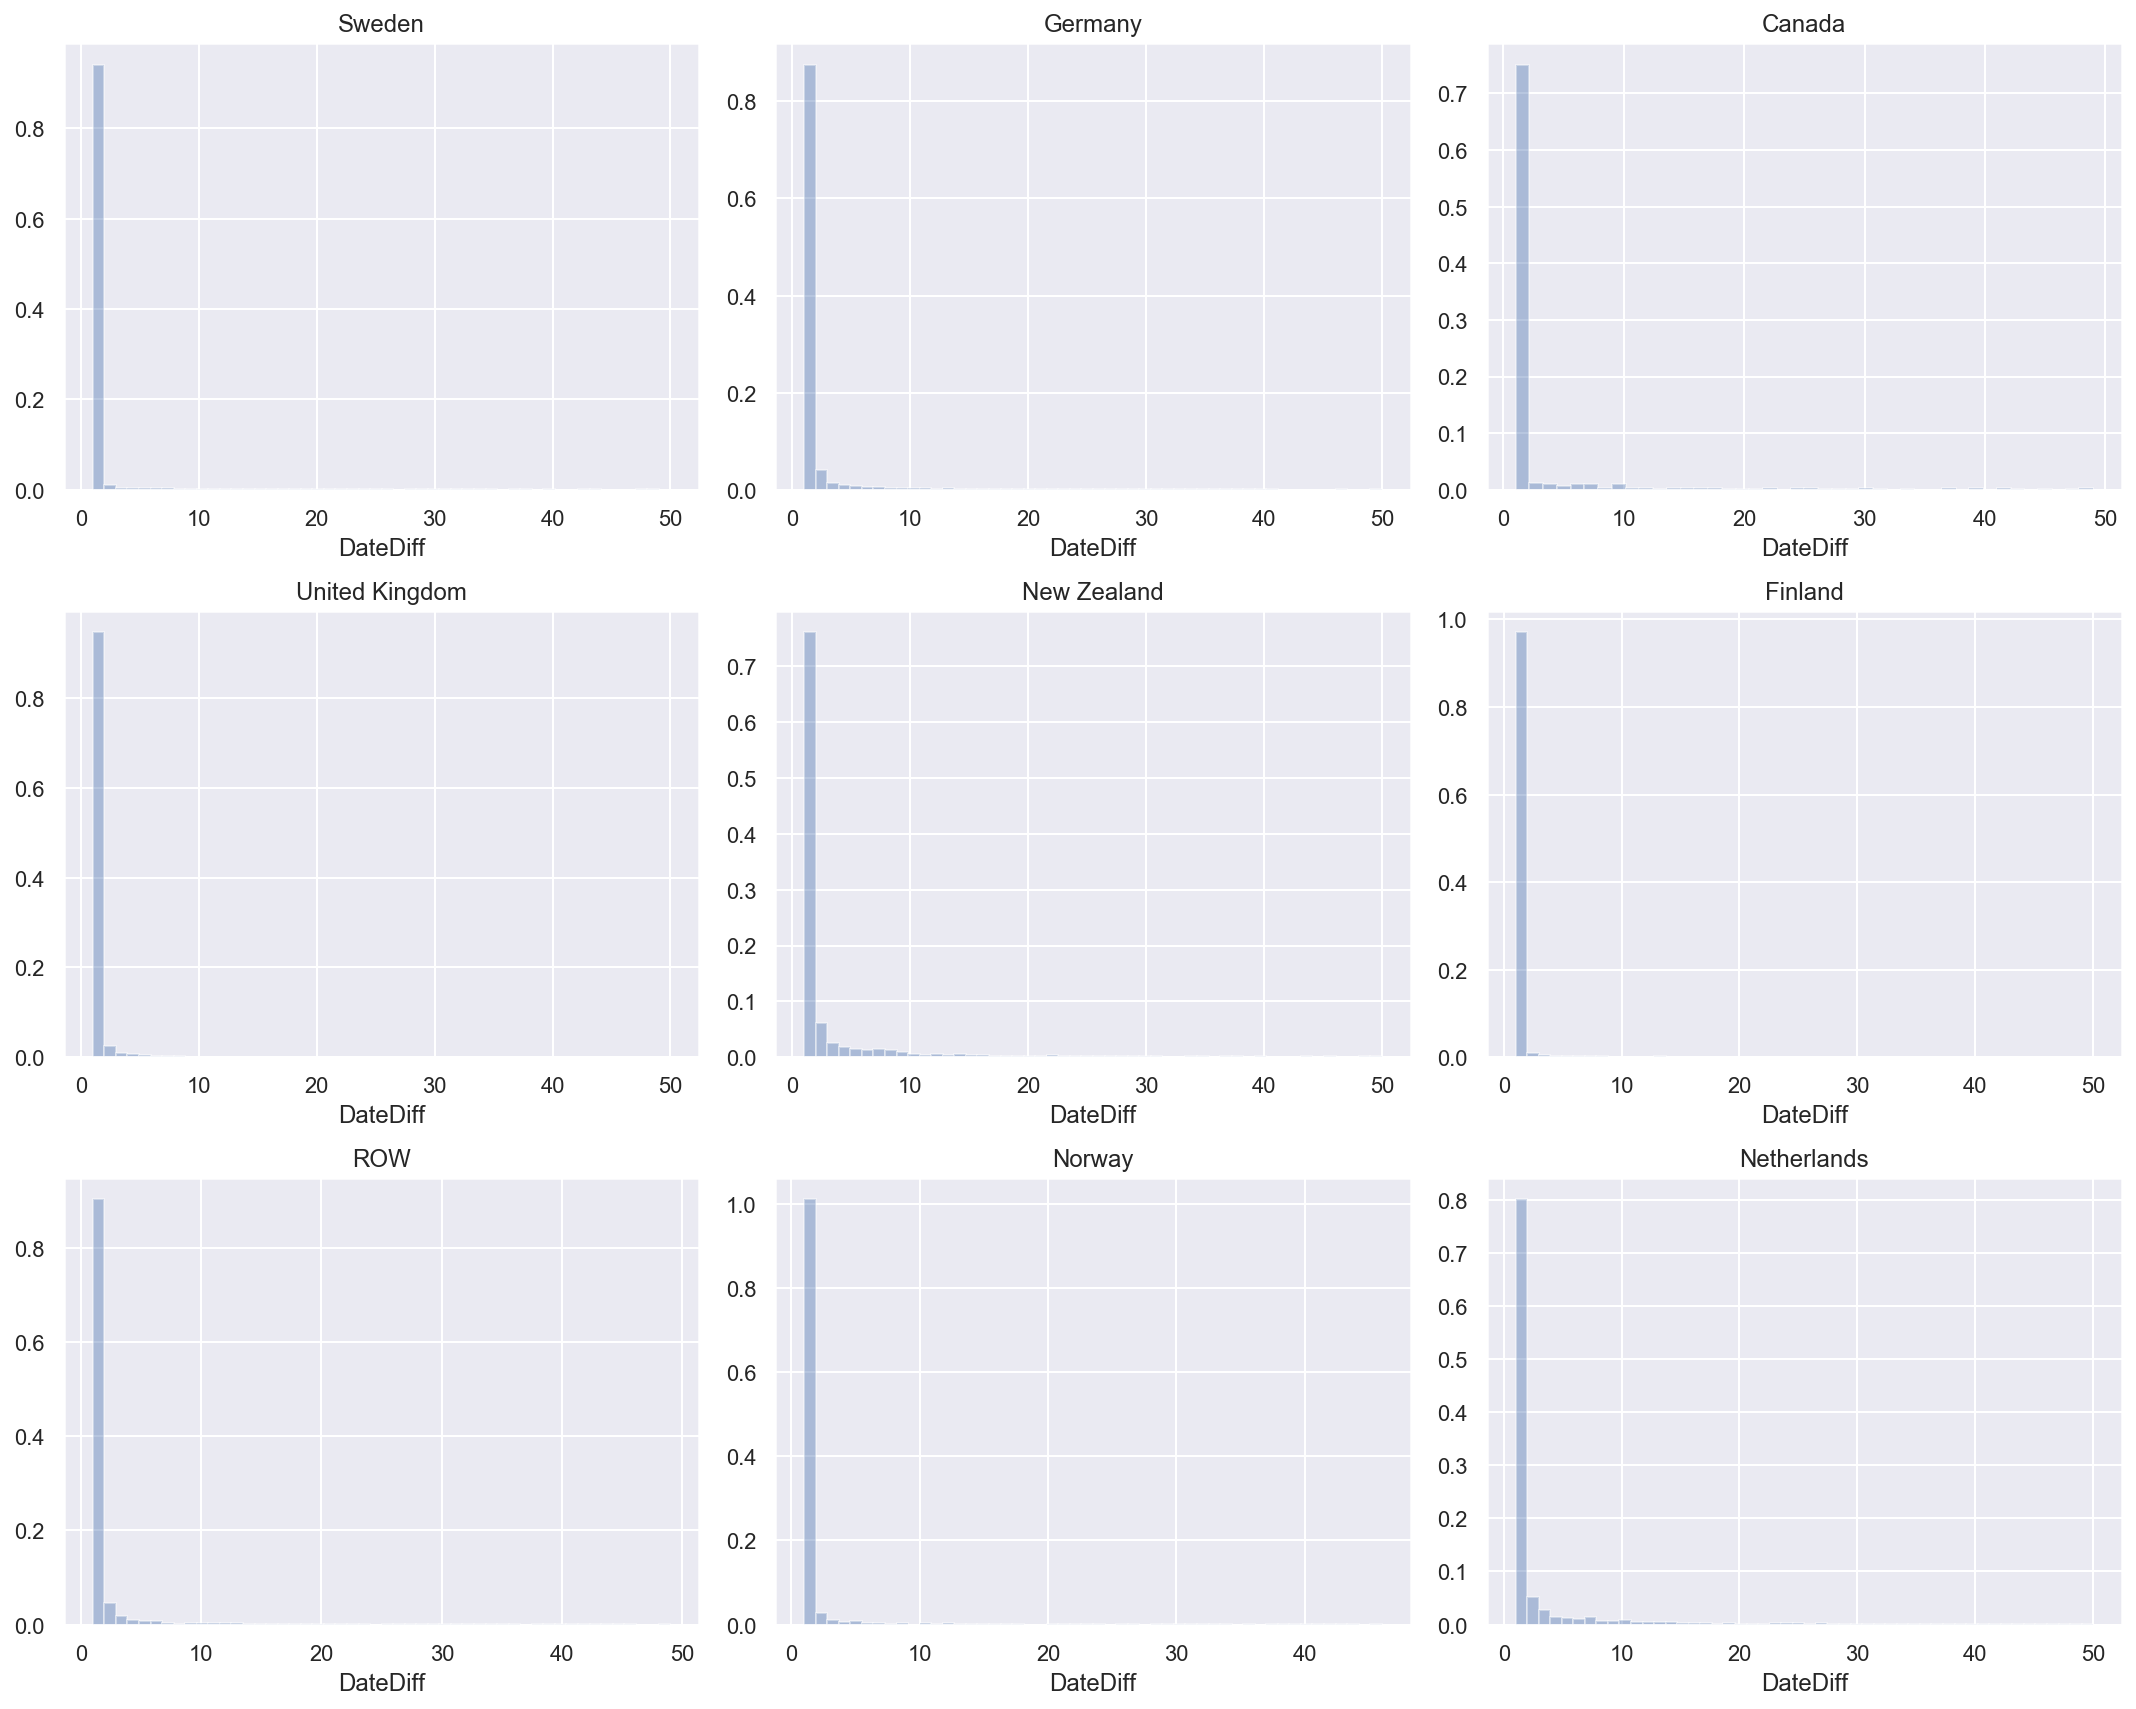

In [41]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))

for ax, country in zip(axes.flat, df.CountryID.unique()):
    df_country = df[(df.DateDiff > 0) & (df.DateDiff <= 50)]
    df_country = df_country[df_country.CountryID == country]
    sns.distplot(df_country.DateDiff, kde=False, norm_hist=True, ax=ax)
    ax.set_title(country)
    
plt.tight_layout()

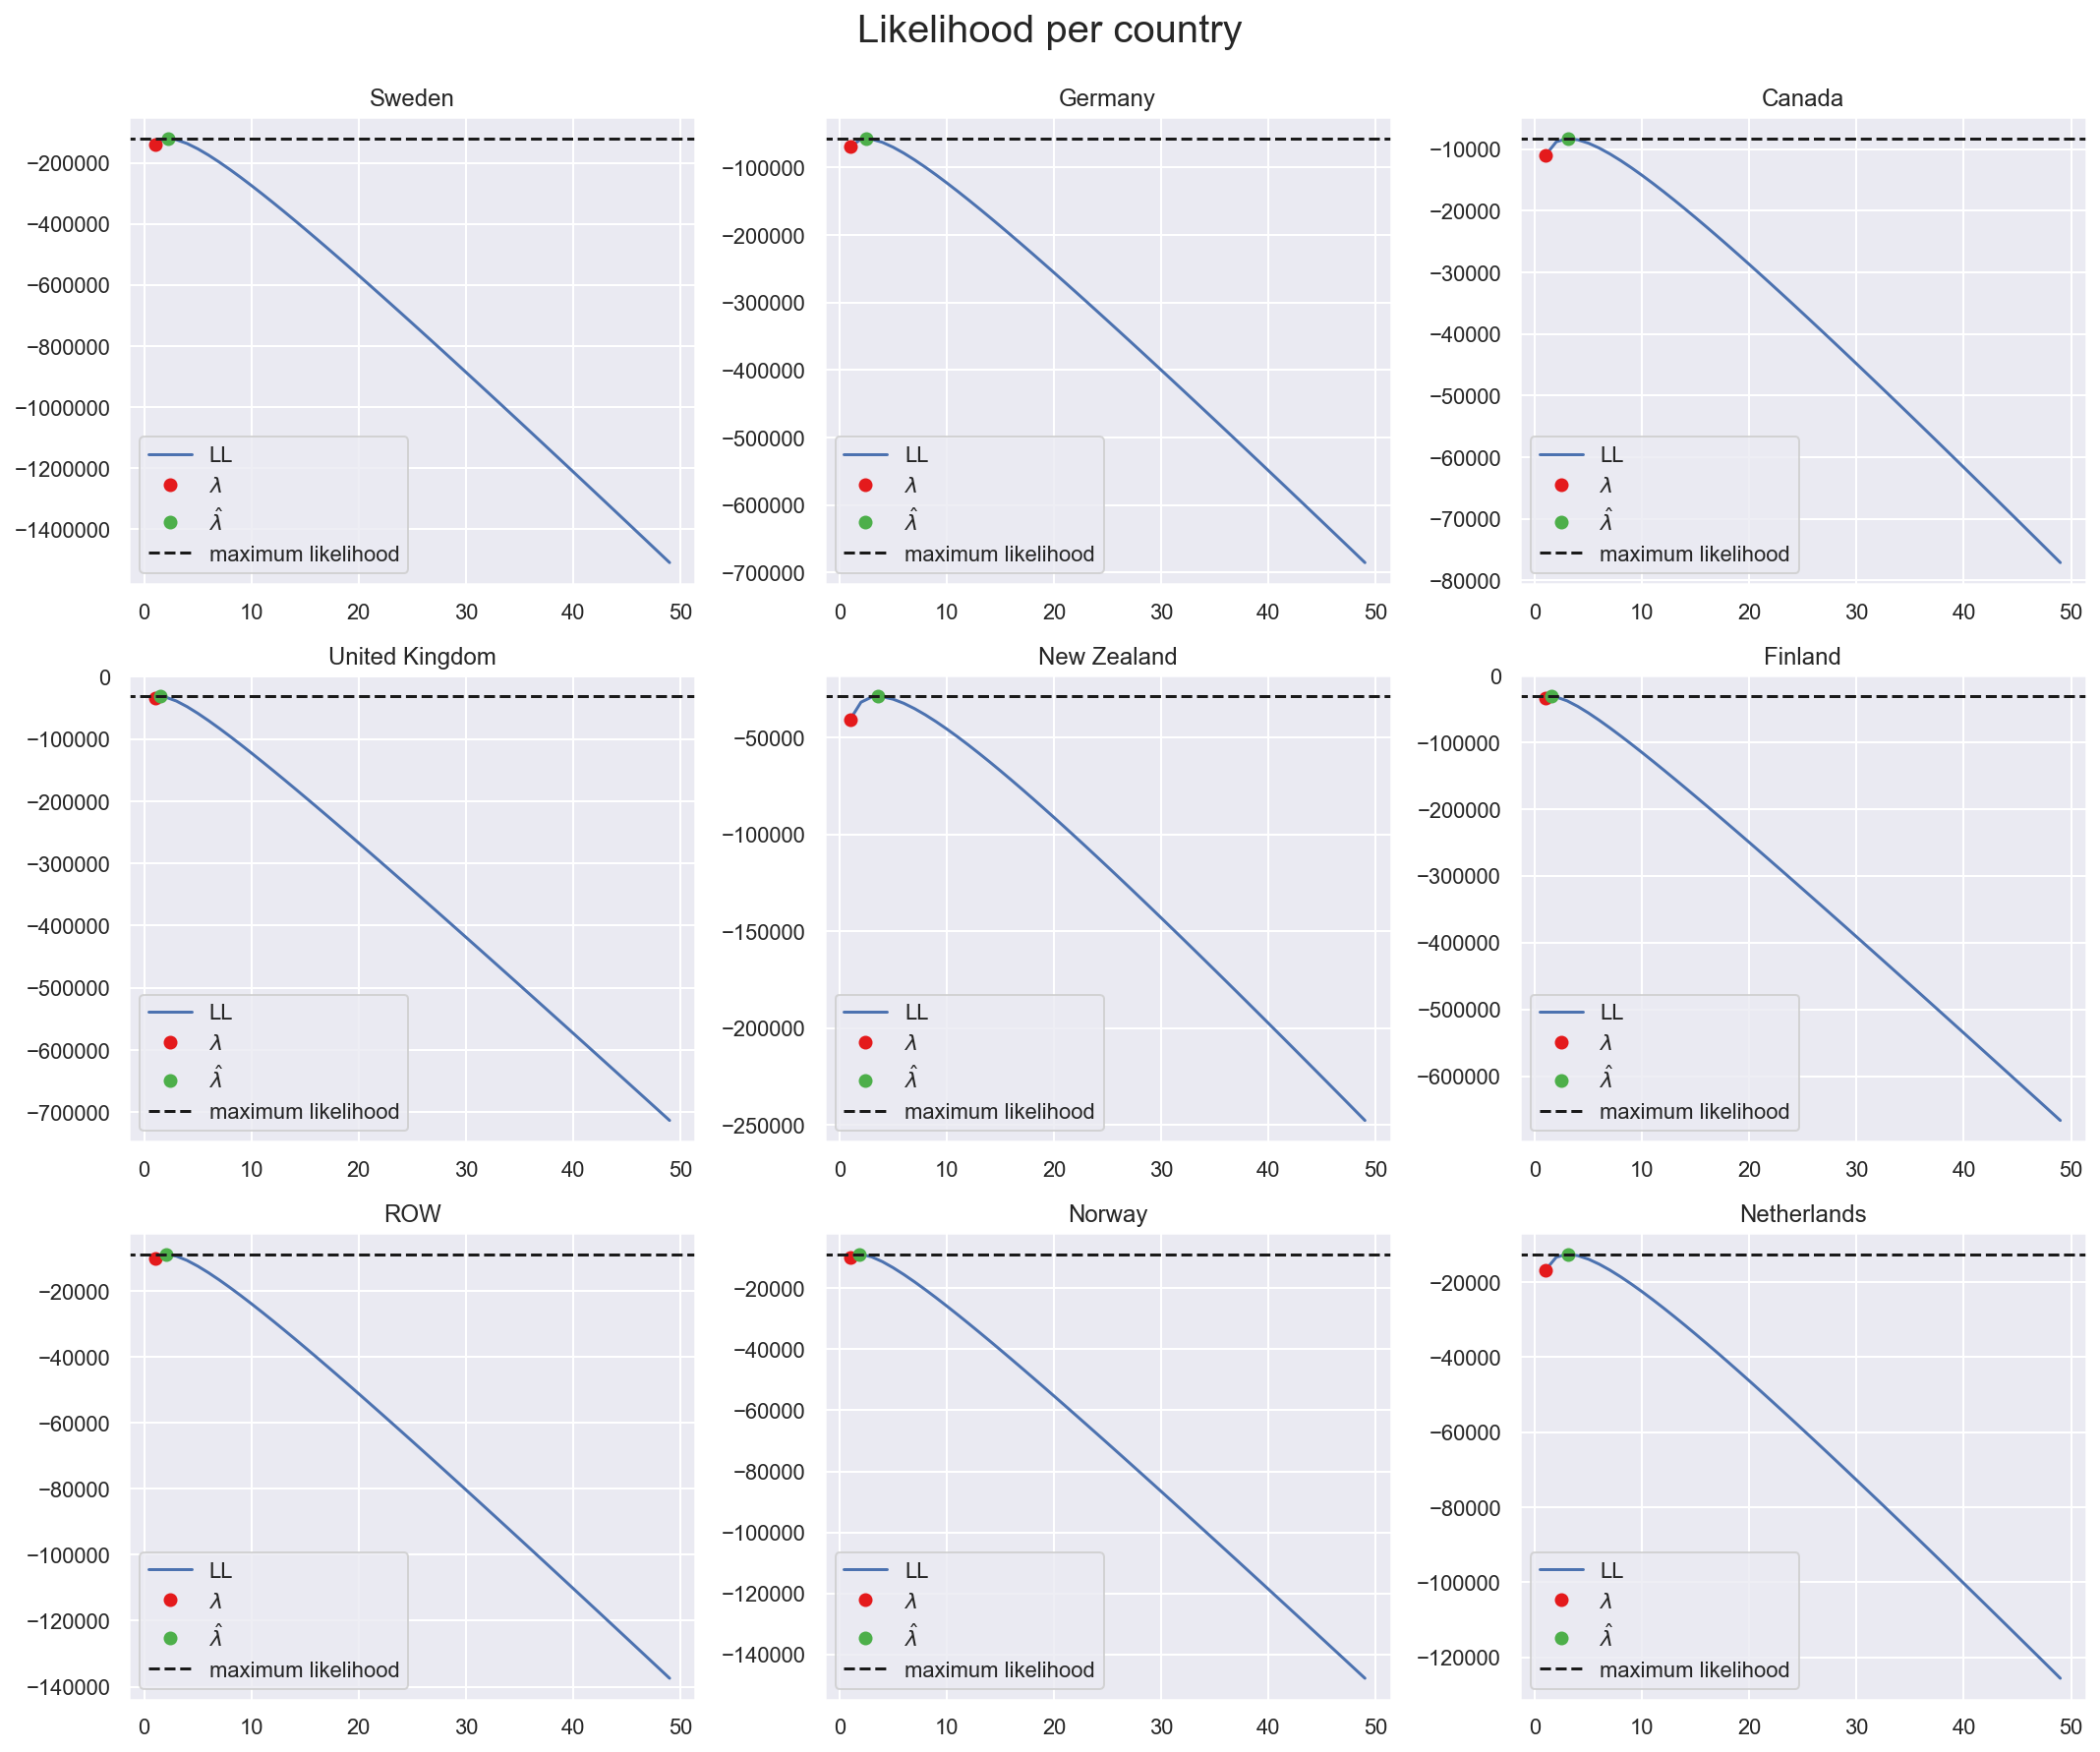

In [42]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))

λ = 1
λ_range = np.arange(0, 50)
λ_hats = {}

plt.suptitle('Likelihood per country', y=1.03, fontsize=20)

for ax, country in zip(axes.flat, df.CountryID.unique()):
    df_country = df[(df.DateDiff > 0) & (df.DateDiff < 51)]
    df_country = df_country[df_country.CountryID == country]
    
    X = df_country.DateDiff
    λ_hat = X.mean()
    λ_hats[country] =  λ_hat
    
    ax.plot(λ_range, [log_likelihood(λ_, X) for λ_ in λ_range], label='LL')
    ax.plot(λ, log_likelihood(λ, X), 'o', color=red, label='$λ$')
    ax.plot(λ_hat, log_likelihood(λ_hat, X), 'o', color=green, label='$\hat{λ}$')

    ax.axhline(y=log_likelihood(λ_hat, X), xmin=-1, xmax=λ_hat, ls='--', c='k', label='maximum likelihood')
    ax.set_title(country)
    ax.legend()
    
plt.tight_layout()

In [43]:
for k,v in λ_hats.items():
    print(f'Country:  {k:<15} Estimated λ:  {v:.2f}')

Country:  Sweden          Estimated λ:  2.24
Country:  Germany         Estimated λ:  2.46
Country:  Canada          Estimated λ:  3.14
Country:  United Kingdom  Estimated λ:  1.51
Country:  New Zealand     Estimated λ:  3.55
Country:  Finland         Estimated λ:  1.54
Country:  ROW             Estimated λ:  2.04
Country:  Norway          Estimated λ:  1.86
Country:  Netherlands     Estimated λ:  3.07


We see all estimated values of $\lambda$ are pretty close to our expected result of 1.

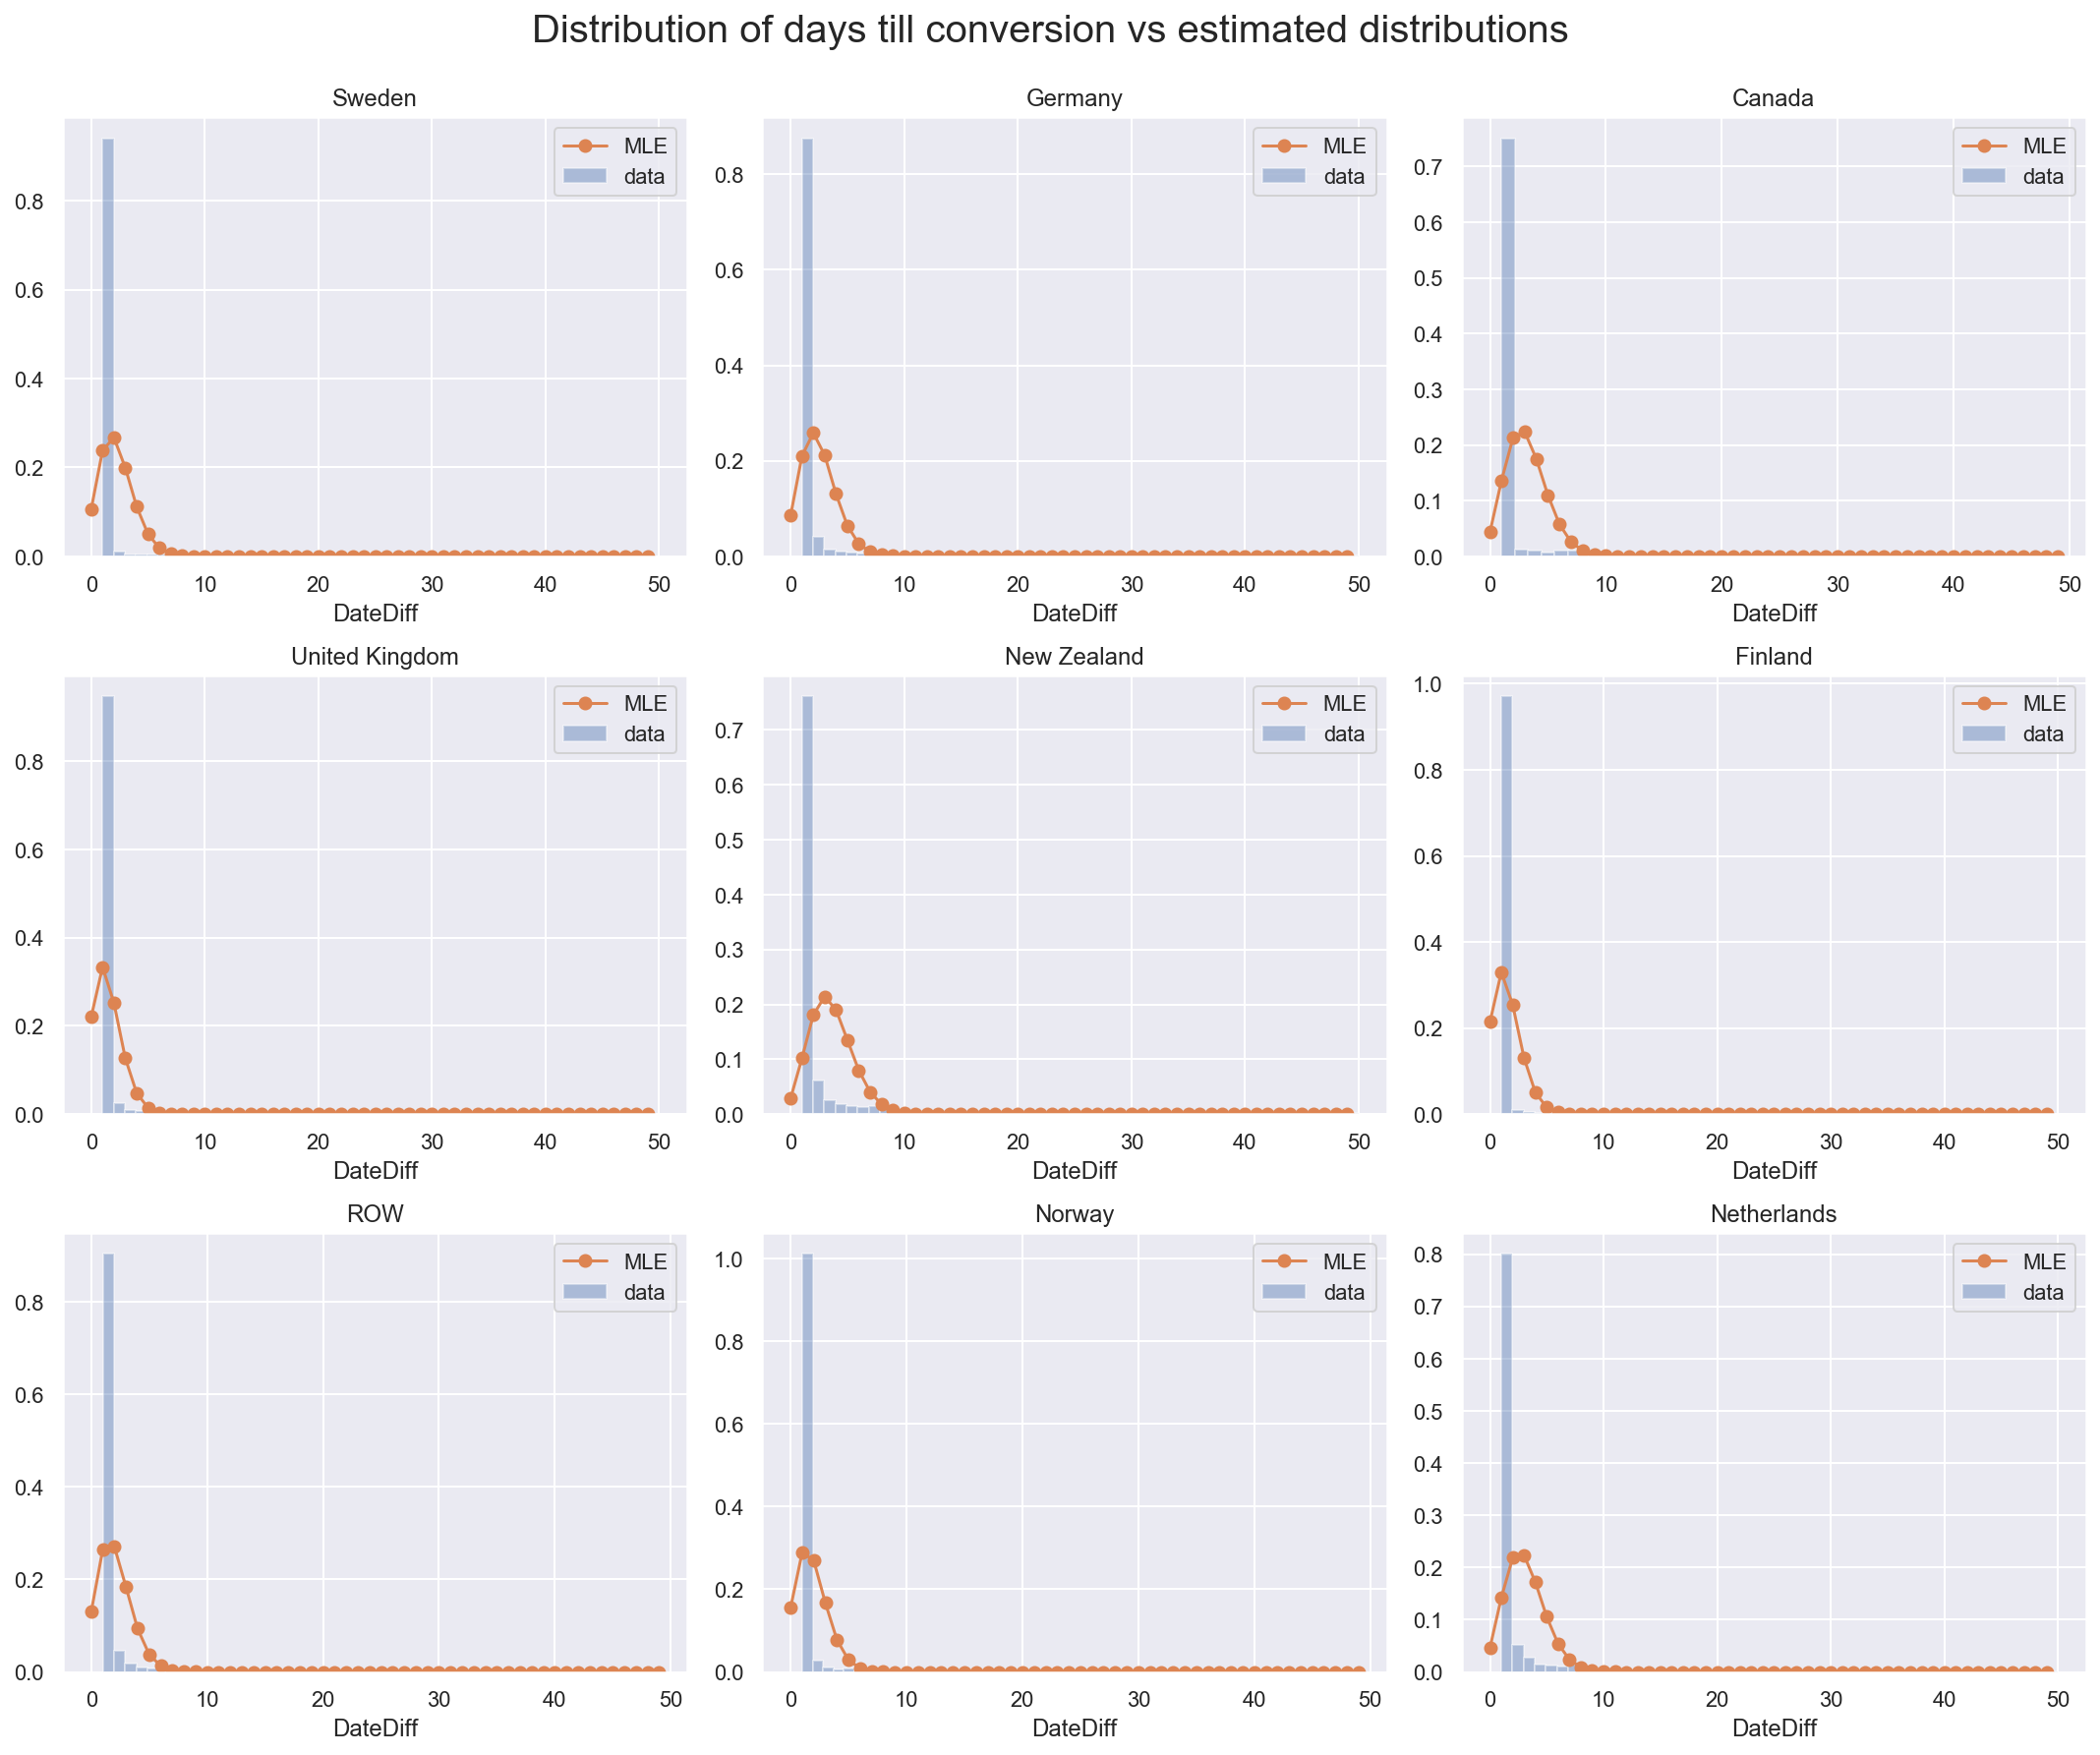

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))

plt.suptitle('Distribution of days till conversion vs estimated distributions',y=1.03, fontsize=20)

for ax, country in zip(axes.flat, df.CountryID.unique()):
    df_country = df[(df.DateDiff > 0) & (df.DateDiff < 51)]
    df_country = df_country[df_country.CountryID == country]
    sns.distplot(df_country.DateDiff, kde=False, norm_hist=True, ax=ax, label='data')
    ax.set_title(country)
    
    pmf = stats.poisson.pmf(λ_range, λ_hats[country])
    ax.plot(λ_range, pmf, '-o', label='MLE')
    ax.legend()
    
plt.tight_layout()

# Bayesian Inference

We will use MCMC to estimate the parameters of the distribution of our data along with a confidence interval for the parameters.

In [45]:
def log_prior(λ):
    if λ > 0:
        return 0
    else:
        return -np.inf

def log_posterior(λ, X):
    logpr = log_prior(λ)
    if np.isinf(logpr): 
        return logpr
    else: 
        return logpr + log_likelihood(λ, X)

In [46]:
valid_date_diffs

,SignupDate,CountryName,CustomerID,Bonuses,DepositDate,DateDiff,CountryID
0,2020-08-30,Sweden,880393,0.0000,2020-08-30,1,Sweden
1,2020-08-30,Germany,880415,28.5000,2020-08-30,1,Germany
2,2020-08-30,Canada,880467,13.3586,2020-08-30,1,Canada
3,2020-08-30,Sweden,880477,3.4136,2020-08-30,1,Sweden
4,2020-08-30,Sweden,880499,0.0000,2020-08-30,1,Sweden
...,...,...,...,...,...,...,...
1399435,2019-06-22,Netherlands,1000000386582,21.2000,2019-06-22,1,Netherlands
1399436,2019-07-03,Netherlands,1000000391138,341.2700,2019-07-03,1,Netherlands
1399437,2019-06-25,Netherlands,1000000387742,34.5800,2019-06-25,1,Netherlands
1399438,2019-06-24,Netherlands,1000000387053,5.1000,2019-06-30,7,Netherlands


# Maximizing the log-posterior

In [47]:
X = valid_date_diffs.DateDiff

λ_range = np.linspace(X.min(), X.max(), 100)

log_pri = np.array([log_prior(λ_) for λ_ in λ_range])
log_lik = np.array([log_likelihood(λ_, X) for λ_ in λ_range])
log_post = np.array([log_posterior(λ_, X) for λ_ in λ_range])

λ_hat = λ_range[log_post.argmax()] # maximum a posterioi estimate MAP

print(f'λ = {λ}')
print(f'λ_hat = {λ_hat:.2f}')

λ = 1
λ_hat = 1.99


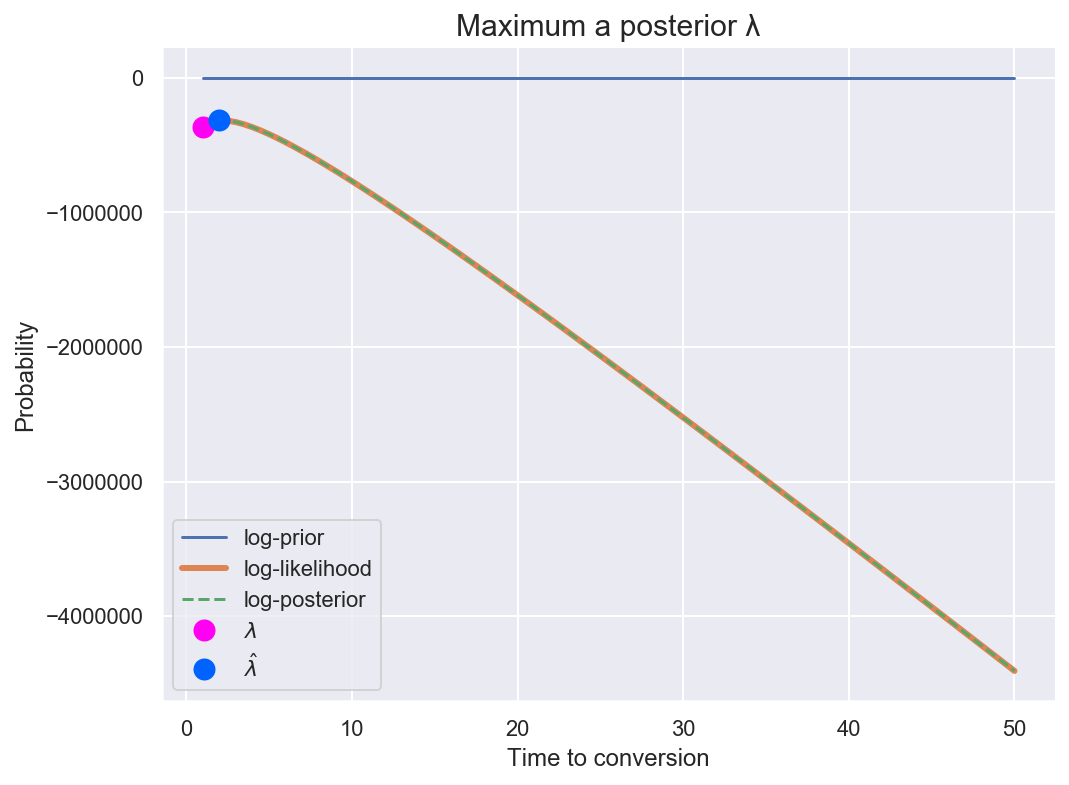

In [48]:
plt.figure(figsize=(8,6))

plt.plot(λ_range, log_pri, label='log-prior')
plt.plot(λ_range, log_lik, lw=3, label='log-likelihood')
plt.plot(λ_range, log_post, ls='--', label='log-posterior')
plt.plot(λ, log_posterior(λ, X), 'o', color='#ff00f2', markersize=10, label='$λ$')
plt.plot(λ_hat, log_posterior(λ_hat, X), 'o', color='#0062ff', markersize=10, label='$\hat{λ}$')

plt.xlabel('Time to conversion', fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend()
plt.title('Maximum a posterior λ', fontsize=15)
sns.despine()

# Bayesian Inference using MCMC

In [49]:
%%time

ndim = 1
nwalkers = 50
nsteps  = 10_000 // nwalkers
nburn = nsteps // 2

guesses = np.random.rand(nwalkers, ndim)
guesses *= 5  # start mu between 0 and 5

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X])
sampler.run_mcmc(guesses, nsteps)

chains = sampler.chain[:, nburn:, :].copy()
sample = sampler.chain[:, nburn:, :].reshape(-1, 1)
sample

CPU times: user 1min 8s, sys: 959 ms, total: 1min 9s
Wall time: 1min 14s


array([[2.15473244],
       [2.15562533],
       [2.15398713],
       ...,
       [2.15141554],
       [2.15290387],
       [2.15079908]])

In [50]:
λ_hat_mean = sample.mean()
λ_hat_std = sample.std()

print(f'λ_hat_mean: {λ_hat_mean:.2f}, λ_hat_std: {λ_hat_std:.5f}')

λ_hat_mean: 2.15, λ_hat_std: 0.00454


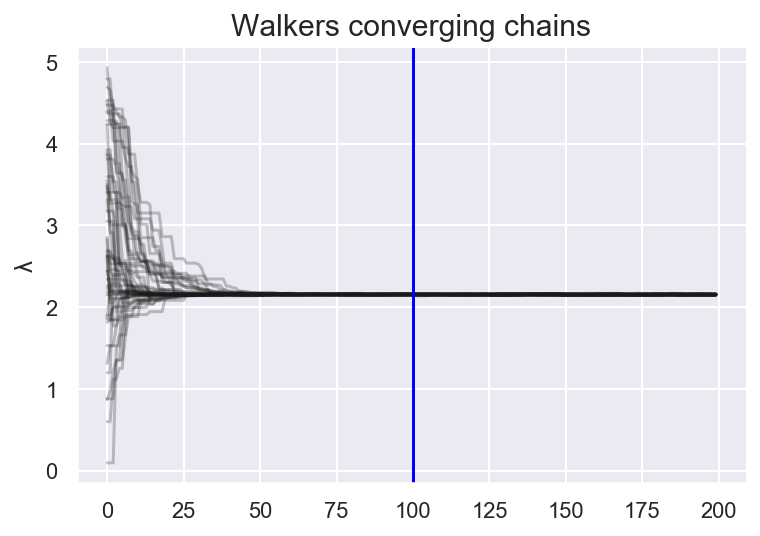

In [51]:
plt.plot(sampler.chain[:,:,0].T, alpha=0.25, c='k');
plt.title('Walkers converging chains', fontsize=15)
plt.ylabel('λ', fontsize=12)
plt.axvline(nburn, color='blue');
sns.despine()

# Estimating RTP paramters assuming a normal distribution

We assume the RTP is normally distributed with mean $\mu = 93$ and standard deviation $\sigma = 20$. 

We will again use Maximum Likelihood Estimate and Bayesian Inference using MCMC to estimate these parameters.

In [52]:
df = pd.read_csv('try.csv')
df.head()

,UserId,BaseBet,BaseWin
0,9400,4.6038,1.3716
1,175,0.0000,0.0000
2,2222,1256.5175,1127.0241
3,2505,192.7000,97.1300
4,2664,8.6676,3.5735


In [53]:
df.describe()

,UserId,BaseBet,BaseWin
count,878209.000000,8.782090e+05,8.782090e+05
mean,439977.844227,1.877341e+03,1.804336e+03
std,254373.851051,3.912373e+04,3.817910e+04
min,1.000000,-8.800000e-03,0.000000e+00
25%,219685.000000,0.000000e+00,0.000000e+00
50%,439239.000000,1.036800e+00,1.500000e-01
75%,659983.000000,1.685110e+01,1.161540e+01
max,880694.000000,1.841609e+07,1.796882e+07


In [54]:
df.isna().sum()

UserId     0
BaseBet    0
BaseWin    0
dtype: int64

In [55]:
# We only care about base bets greater than 100.
df_gt_100 = df[(df.BaseBet > 100)]
df_gt_100

,UserId,BaseBet,BaseWin
2,2222,1256.5175,1127.0241
3,2505,192.7000,97.1300
7,4026,1262.4178,1278.9457
8,4980,1105.3377,941.0309
10,6341,16486.5501,17734.4633
...,...,...,...
878188,866801,2082.1500,1995.5100
878190,869533,1323.7000,1203.8900
878191,870746,2929.9940,1960.6973
878197,875868,207.8000,157.8000


# Calculate RTP 

In [56]:
df_gt_100['RTP'] = df_gt_100.BaseWin / df_gt_100.BaseBet * 100
df_gt_100

,UserId,BaseBet,BaseWin,RTP
2,2222,1256.5175,1127.0241,89.694262
3,2505,192.7000,97.1300,50.404774
7,4026,1262.4178,1278.9457,101.309226
8,4980,1105.3377,941.0309,85.135149
10,6341,16486.5501,17734.4633,107.569280
...,...,...,...,...
878188,866801,2082.1500,1995.5100,95.838917
878190,869533,1323.7000,1203.8900,90.948855
878191,870746,2929.9940,1960.6973,66.918134
878197,875868,207.8000,157.8000,75.938402


In [57]:
df_gt_100.describe()

,UserId,BaseBet,BaseWin,RTP
count,136402.000000,1.364020e+05,1.364020e+05,136402.000000
mean,407854.206339,1.205183e+04,1.159092e+04,86.998300
std,283242.310525,9.865357e+04,9.628885e+04,24.292897
min,3.000000,1.000050e+02,0.000000e+00,0.000000
25%,141255.250000,2.708540e+02,2.145902e+02,78.143391
50%,384043.500000,9.375437e+02,8.135231e+02,90.060417
75%,665071.750000,4.304168e+03,4.041077e+03,96.960584
max,880684.000000,1.841609e+07,1.796882e+07,2714.248842


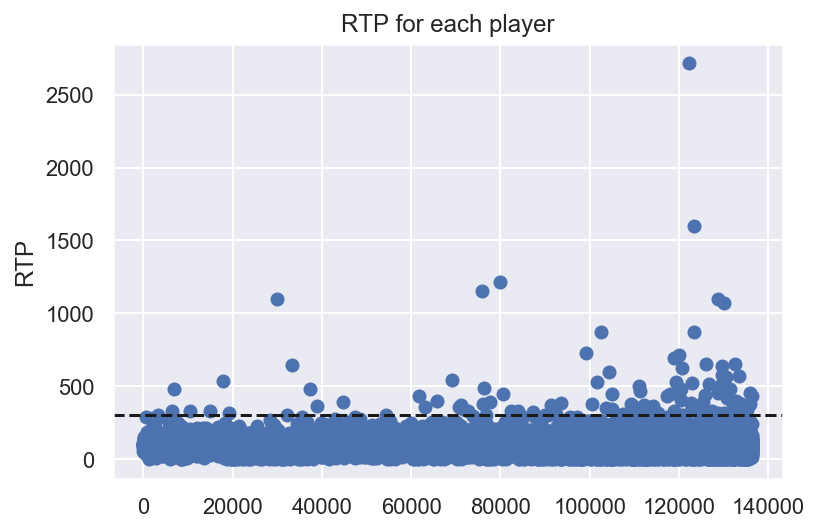

In [58]:
plt.title('RTP for each player')
plt.scatter(np.arange(len(df_gt_100)), df_gt_100['RTP'])
plt.axhline(y=300, ls='--', c='k')
plt.ylabel('RTP');

In [59]:
print('Percentage of players with an RTP greater than 300%:', 
      f'{(df_gt_100.RTP > 300).sum() / len(df_gt_100) * 100:.3f}%')

Percentage of players with an RTP greater than 300%: 0.075%


We see there are extreme outliers in the dataset and since an RTP greater than 300% is highly unlikely (<1% of the dataset) we will remove these outliers. 

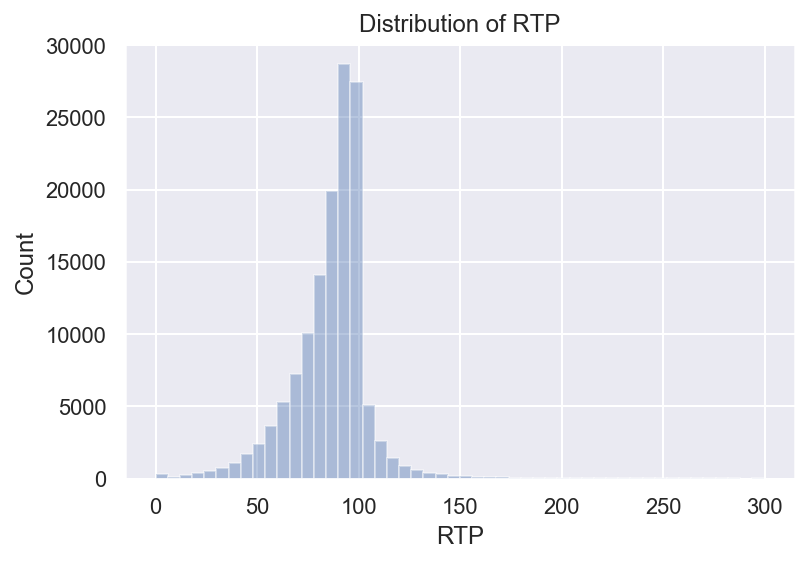

In [60]:
df_gt_100 = df_gt_100[df_gt_100.RTP < 300]

sns.distplot(df_gt_100.RTP, kde=False)
plt.title('Distribution of RTP')
plt.ylabel('Count');

# MLE for RTP

In [61]:
μ = 93
σ = 20

X = df_gt_100.RTP

In [62]:
def log_likelihood(θ, X):
    μ, σ = θ
    return stats.norm.logpdf(X, loc=μ, scale=σ).sum()

In [63]:
μ_hat = X.mean()
σ_hat = X.std()

print(f'μ: {μ}, σ: {σ}')
print()
print(f'μ_hat: {μ_hat:.2f}, σ_hat: {σ_hat:.2f}')

μ: 93, σ: 20

μ_hat: 86.69, σ_hat: 19.75


In [64]:
μ_range = np.linspace(μ_hat*0.95, μ_hat*1.05, 100)
σ_range = np.linspace(σ_hat*0.95, σ_hat*1.05, 100)

μs, σs = np.meshgrid(μ_range, σ_range)
μs.shape, σs .shape

((100, 100), (100, 100))

In [65]:
%%time
log_likes = np.apply_along_axis(log_likelihood, 0, (μs, σs), X)
log_likes

CPU times: user 1min 13s, sys: 2.91 s, total: 1min 16s
Wall time: 1min 21s


array([[-604004.40847423, -603858.91861032, -603716.3979273 , ...,
        -603716.3979273 , -603858.91861032, -604004.40847423],
       [-603981.20873452, -603836.02776619, -603693.80967477, ...,
        -603693.80967477, -603836.02776619, -603981.20873452],
       [-603958.38984007, -603813.51678463, -603671.60032216, ...,
        -603671.60032216, -603813.51678463, -603958.38984007],
       ...,
       [-603275.13729052, -603155.58053339, -603038.46371008, ...,
        -603038.46371008, -603155.58053339, -603275.13729052],
       [-603281.24758672, -603161.92096767, -603045.02958574, ...,
        -603045.02958574, -603161.92096767, -603281.24758672],
       [-603287.59265508, -603168.49551024, -603051.82891938, ...,
        -603051.82891938, -603168.49551024, -603287.59265508]])

In [66]:
max_μ, max_σ = np.unravel_index(log_likes.argmax(), log_likes.shape)
max_μ, max_σ

(49, 49)

In [74]:
max_log_like = log_likes[max_μ, max_σ]

best_μ = μs[max_μ, max_σ]
best_σ = σs[max_σ, max_μ]
print(f'The mean that maximizes the log-likelihood is {best_μ:.2f}')
print(f'The standard deviation that maximizes the log-likelihood is {best_σ:.2f}')

The mean that maximizes the log-likelihood is 86.65
The standard deviation that maximizes the log-likelihood is 19.74


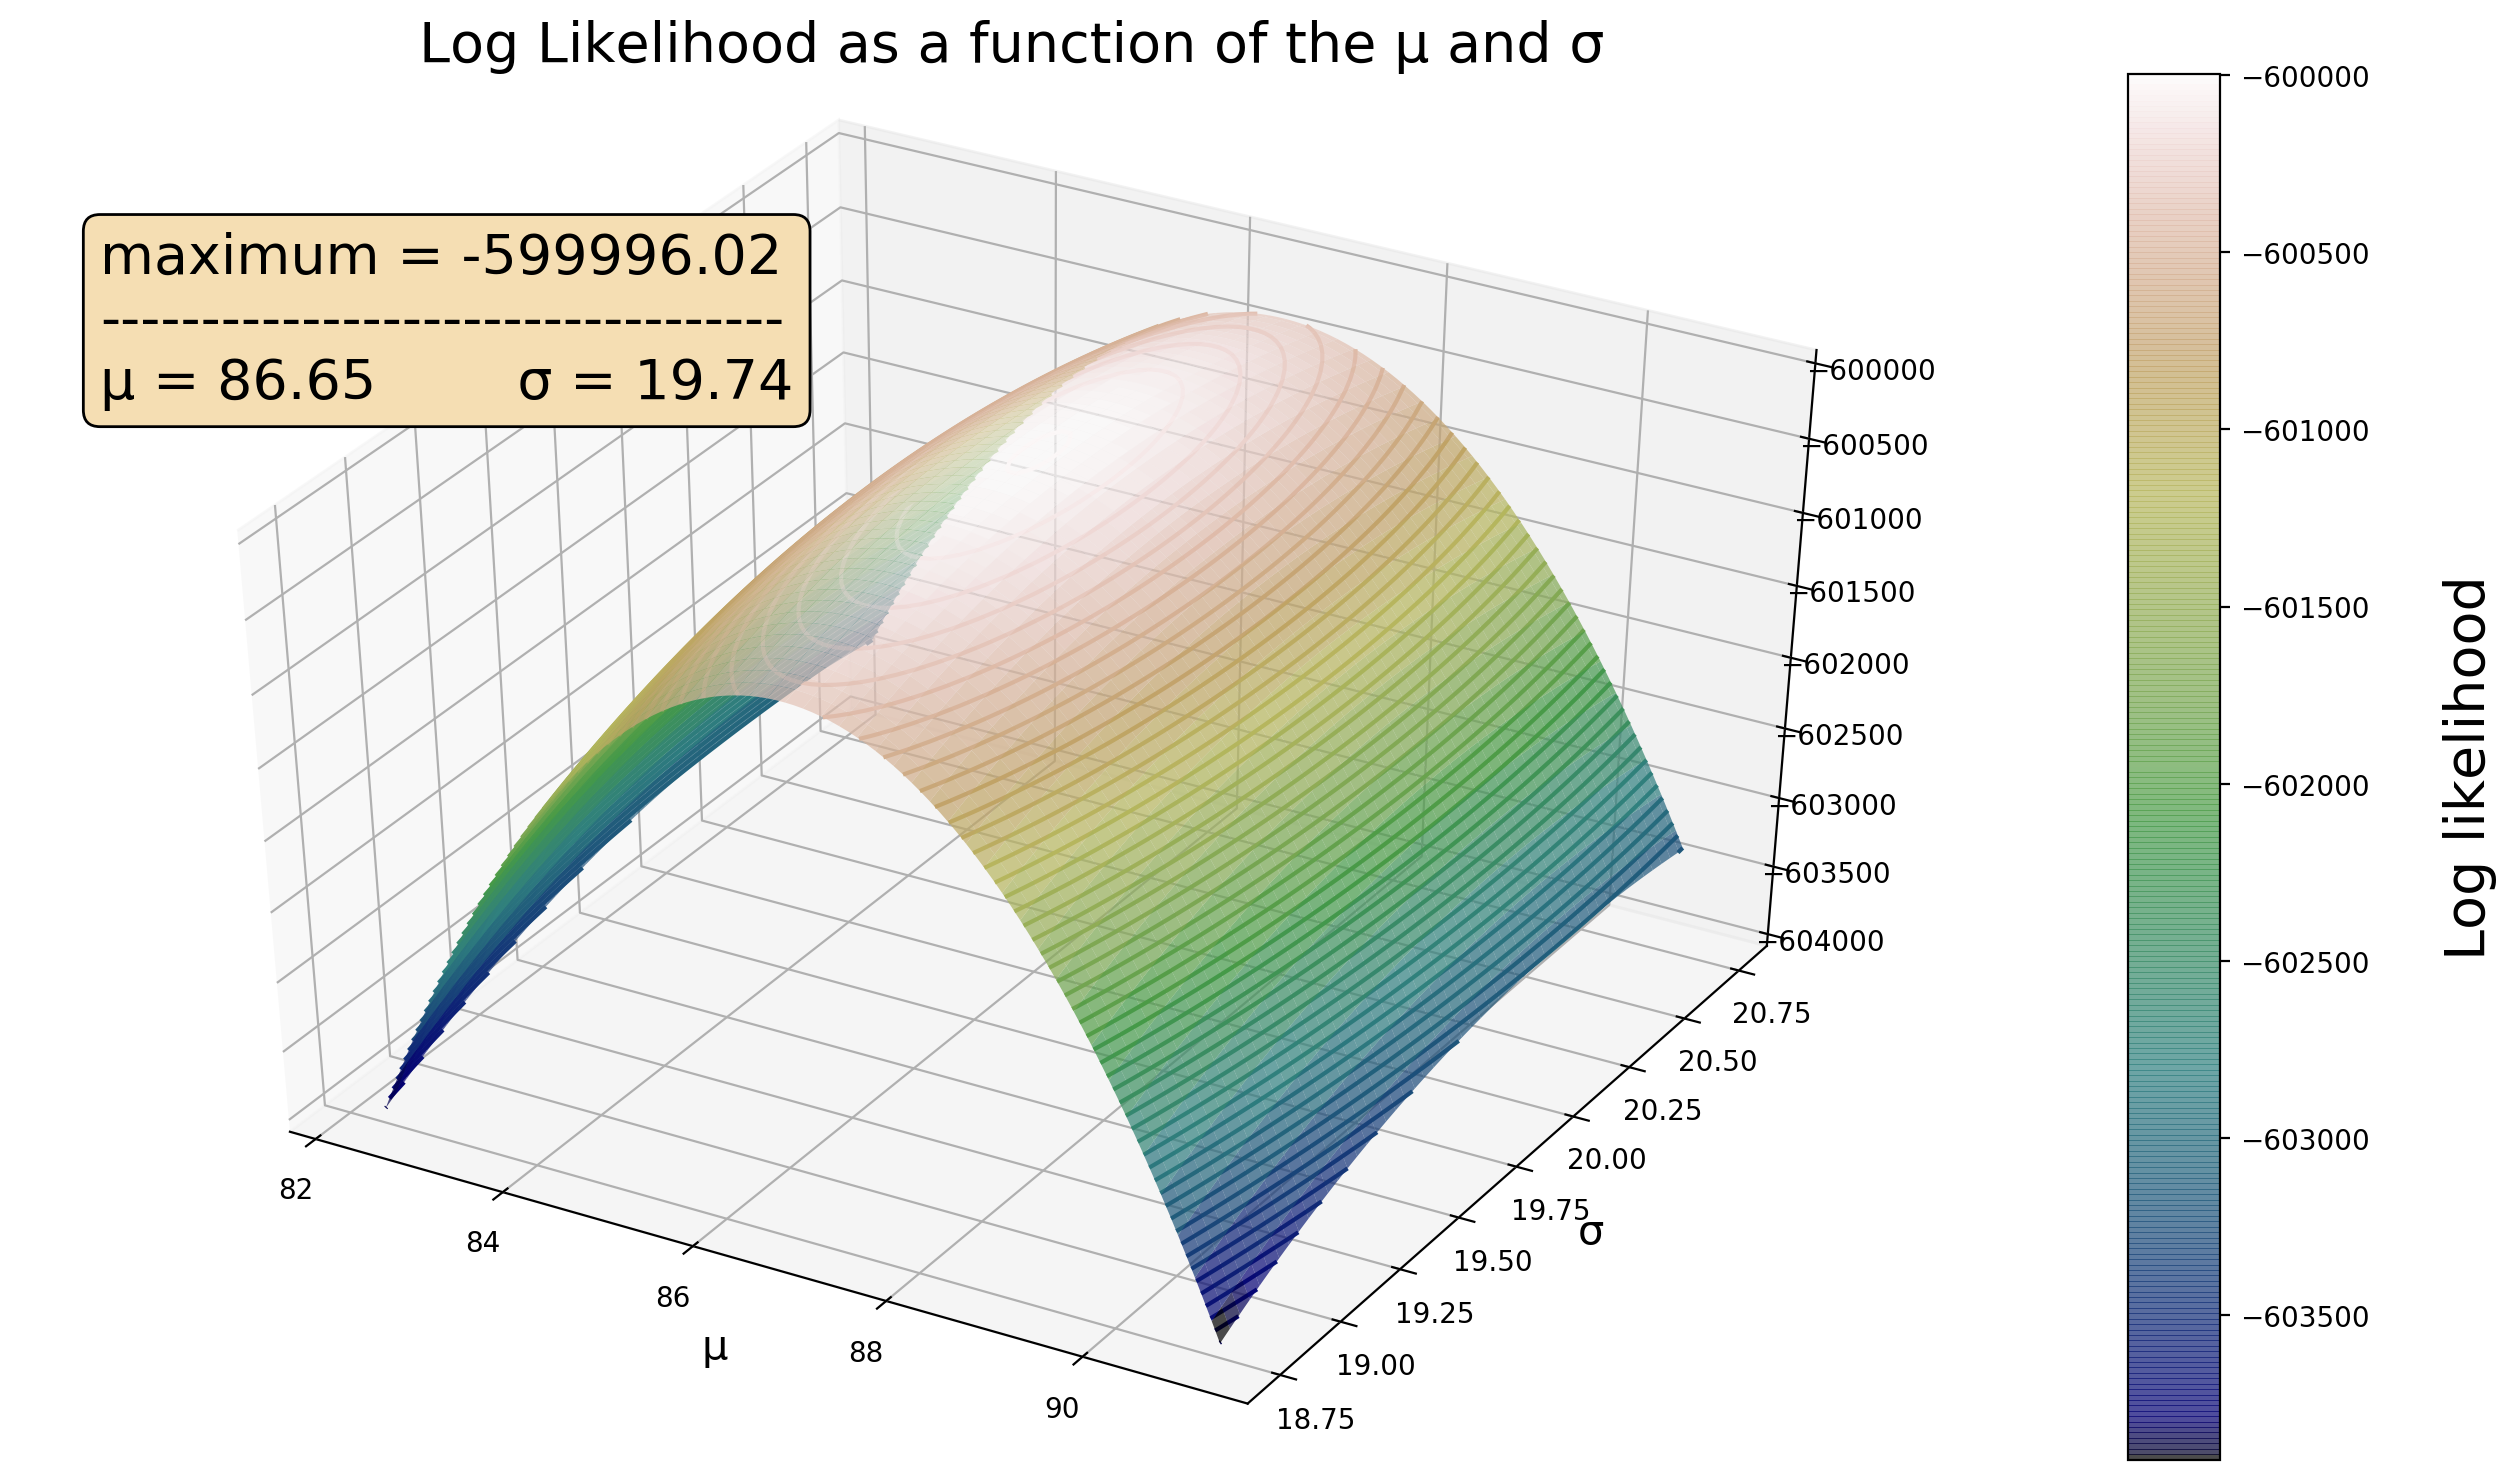

In [68]:
mpl.rc_file_defaults()

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

ax.set_title('Log Likelihood as a function of the μ and σ', y=1.01, fontsize=20, pad=40)

ax.set_xlabel('μ', fontsize=15)
ax.set_ylabel('σ', fontsize=15)

surf = ax.plot_surface(μs, σs, log_likes, alpha=0.7, cmap='gist_earth')
ax.contour3D(μs, σs, log_likes, 50, cmap='gist_earth')

props = dict(boxstyle='round', facecolor='wheat')

description = f'''maximum = {max_log_like:.2f}
----------------------------------
μ = {best_μ:.2f}        σ = {best_σ:.2f}'''

fig.text(0.15, .70, description, bbox=props, fontsize=20)

ax.view_init(elev=40, azim=-60)
cb = fig.colorbar(surf, ax=ax, aspect=15)
cb.set_label('\nLog likelihood', fontsize=20)
plt.show() 

We see that the log-likelihood is much more sensitive to the value of $\mu$ than it is to $\sigma$.

<hr style="border: 10px dotted #a6a6a6;
           border-style: none none dotted; 
           color: #fff; 
           background-color: #fff;
           margin: 0 45%;">

# Bayesian Inference using MCMC

In [69]:
def log_prior(θ):
    μ, σ = θ
    # both parameters need to be positive
    if μ > 0 and σ > 0:
        return 0
    else:
        return -np.inf

def log_posterior(θ, X):
    pri = log_prior(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [70]:
%%time

ndim = 2
nwalkers = 50
nsteps  = 10000 // nwalkers
nburn = nsteps // 2

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] *= 200  # start mu between 0 and 100
guesses[:, 1] *= 40    # start sigma between 0 and 40

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X])
sampler.run_mcmc(guesses, nsteps)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
chains = sampler.chain[:, nburn:, :].copy()
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)
sample

CPU times: user 1min 15s, sys: 3.96 s, total: 1min 19s
Wall time: 1min 23s


array([[86.73138758, 19.76431945],
       [86.75386398, 19.78720294],
       [86.75386398, 19.78720294],
       ...,
       [86.67304732, 19.72355577],
       [86.68291714, 19.73240572],
       [86.65811741, 19.71164292]])

In [77]:
μ_sample, σ_sample = sample[:,0], sample[:,1]
μ_hat, σ_hat = μ_sample.mean(), (σ_sample).mean()

print(f'μ = {μ}   μ_hat = {μ_hat:.2f}')
print(f'σ = {σ}   σ_hat = {σ_hat:.2f}')

μ = 93   μ_hat = 86.69
σ = 20   σ_hat = 19.75


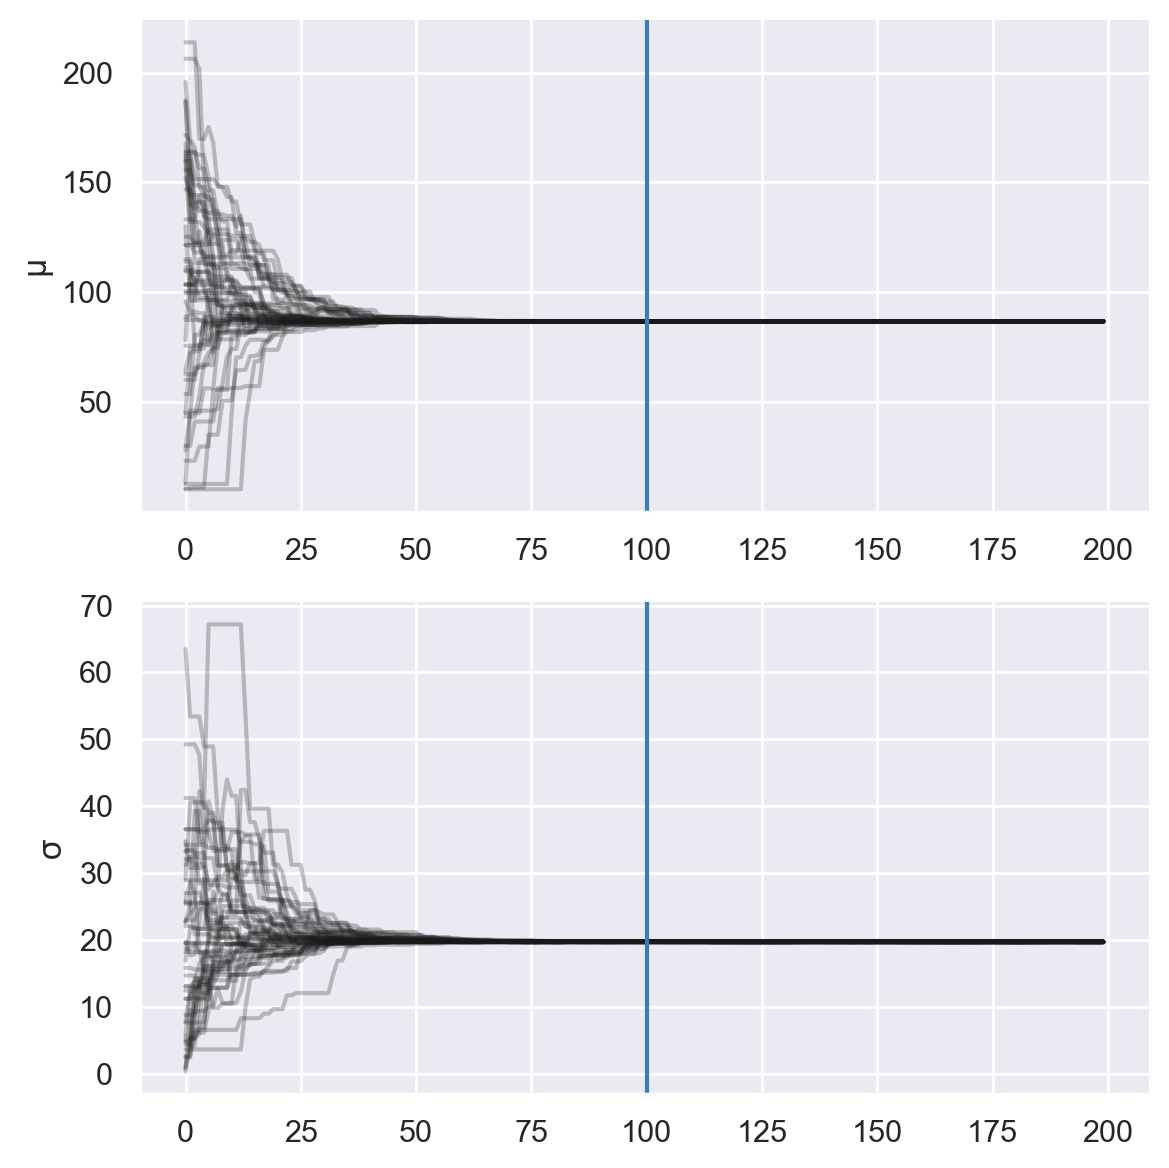

In [72]:
sns.set()
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

for i, varname in enumerate(['μ', 'σ']):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25);
    ax.axvline(nburn, color=blue)
    ax.set_ylabel(varname)

fig.tight_layout()
sns.despine()

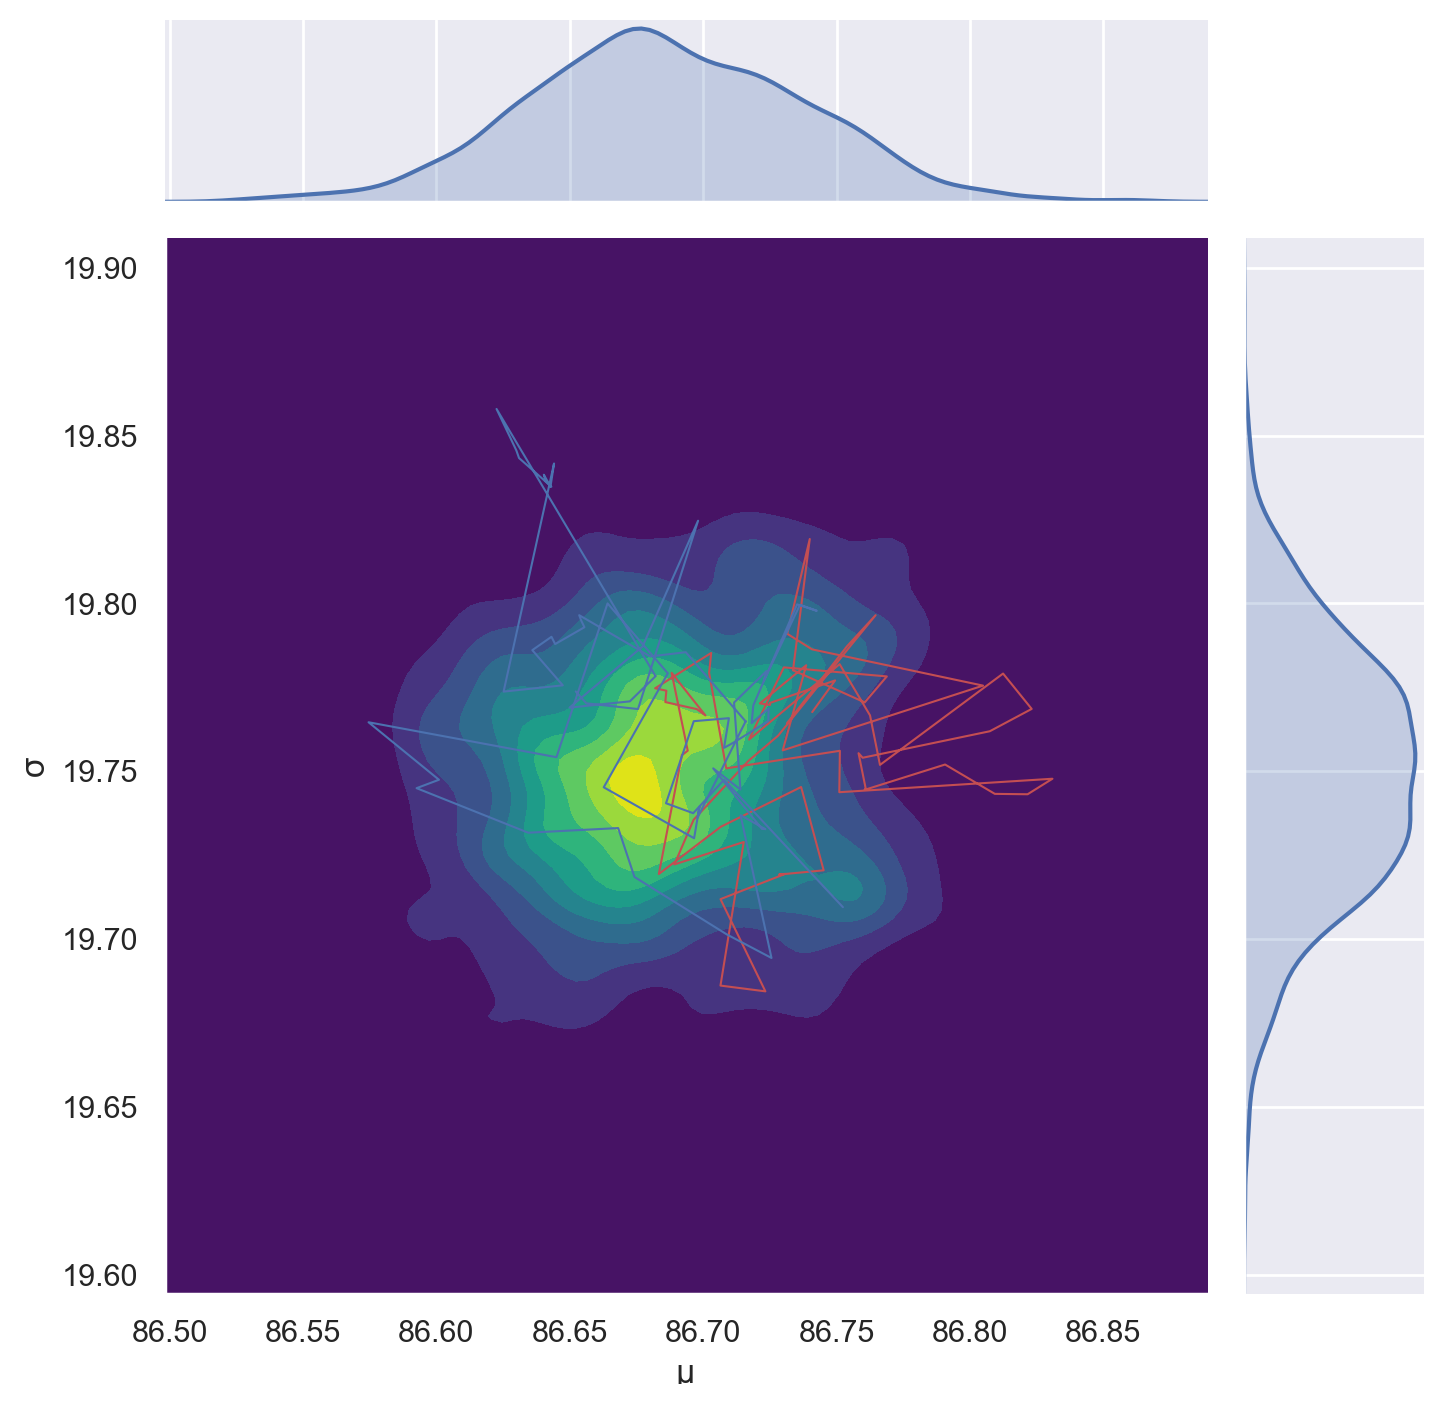

In [79]:
g = sns.jointplot(
    sampler.chain[:, nburn :, 0].ravel(), 
    sampler.chain[:, nburn:, 1].ravel(), 
    kind='kde', cmap='viridis', height=7)

g.set_axis_labels('μ', 'σ')

for i, c in enumerate('rb'):
    g.ax_joint.plot(chains[i, :, 0], chains[i, :, 1], lw=0.75, color=c)